In [29]:
import numpy as np # быстрые математические вычисления, работа с массивами
import matplotlib.pyplot as plt # рисует графики, поля, траектории
from scipy.integrate import solve_ivp
from sympy import symbols, diff, lambdify

In [30]:
def f1(alpha):  # тут вводим альфу
    def rhs(t, X):      # правая часть ДУ (Differential Equation Right-Hand Side)
        x, y = X        # X — это вектор состояния системы (x - координата, y - скорость)
        return [y, -alpha*y +pow(x,5) -5*pow(x,3)+4*x]  # возвращает dx/dt и dy/dt
    return rhs

# x' = y
# y' = x^5 - 5x^3 + 4x - alpha*y
#

In [31]:
# Функция для вычисления векторного поля
def vector_field_calculation(rhs, limits, N=16): #
    xs,ys = limits

    xs = np.linspace(xs[0],xs[1],N) # генерируем сетку равномерно распределенных чисел в заданном интервале
    ys = np.linspace(ys[0],ys[1],N)
    U, V = np.zeros((N,N)), np.zeros((N,N)) # переписываем в эти два массива нули (массивы скоростей)
        #U[i][j] будет хранить компоненту скорости по оси x
        #V[i][j] - компоненту скорости по оси у для точки с координатами (x[j], y[j]?)

    for i, y in enumerate (ys): # i получает индекс (0, 1, 2, ...). y[i] получает значение элемента.
            for j,x in enumerate (xs):
                u,v = rhs(0.0, [x,y])

                U[i][j] = u
                V[i][j] = v
            # проходим по всемм точкам сетки с координатами х у
            # вызываем функцию rhs(0.0, [x,y]), которая возвращает
            #вектор скорости в этой точке
            #значение компонент вектора u v сохраняются в массивы U V
    return xs,ys,U,V



In [32]:
#Функция для рисования векторного поля
def drawing_vector_field(rhs, limits):
    #plt.close() - можно раскоментить, но тогда придется перекинуть отрисовку сепаратрис пониже (...)
    xlims, ylims = limits # граница x граница y
    plt.xlim(xlims[0],xlims[1]) # задаем границы поля по x
    plt.ylim(ylims[0],ylims[1]) # задаем границы поля по y
    xs,ys,U,V = vector_field_calculation(rhs, limits) # Вызывает вспомогательную функцию vector_field_calculation. Эта функция рассчитывает координаты сетки (xs, ys) и компоненты векторов скоростей (U, V) для каждой точки сетки, используя правые части уравнений (rhs).
    plt.quiver(
        xs, ys, U, V, # Передает plt.quiver основные данные: (xs, ys) — начальные координаты каждой стрелки; (U, V) — X и Y компоненты (направление и длина) каждой стрелки.
        alpha=1, #Устанавливает прозрачность стрелок на 1.0 (полностью непрозрачные).

        width=0.002,      # Толщина стрелки (рекомендуется 0.001-0.005)
        headwidth=3,      # Ширина головки стрелки (стандартно ~3)
        headlength=5      # Длина головки стрелки (стандартно ~5)
    ) # plt.quiver рисует именно вектор из xs ys, в направлении



In [33]:
# поиск производной по функции
x = symbols('x')
f_x = x**5 - 5*x**3+4*x
df_dx = diff(f_x,x)
print(df_dx)

5*x**4 - 15*x**2 + 4


In [34]:
#создаем якобиан по альфе и иксу
def create_jacobian(alpha, x_value):
    # x'' + 2(sigma)x' + (gamma)y = 0 из этого уравнения сделали системку:
    # x' = 0x + y
    # y' = (5x^4 -15x^2 + 4)*x + (-alpha)*y
    #return np.array([[0, 1],[5*pow(x,4)-15*pow(x,2)+4, -alpha]])
    x = symbols('x')
    f_x = x**5 - 5*x**3+4*x
    df_dx = diff(f_x,x)
    df_dx_val = df_dx.subs(x,x_value)
    #print(type(df_dx_val))
    J = np.array([[0, 1],[df_dx_val, -alpha]], dtype=np.float64)
    return J

In [35]:
#считаем собственные числа и вектора
def solve_eigenvalues_and_jacobian(alpha,x):
    J = create_jacobian(alpha,x)
    # Вычисление собственных чисел и векторов
    eigenvalues, eigenvectors = np.linalg.eig(J)
    return eigenvalues, eigenvectors
    # eigenvalues - массив содержащий собственные числа (lambda1, lambda2)
    # eigenvectors - массив содержащий соответствующие собственные векторы

In [36]:
# пределяет тип состояния равновесия по текущим собственным числам
def stability_type(eigenvalues): # получает значения собственных чисел
    lambda_1 = eigenvalues[0] # первое собственное число
    lambda_2 = eigenvalues[1] # второе собственное число
    r1, r2 = lambda_1.real, lambda_2.real
    i1, i2 = lambda_1.imag, lambda_2.imag

    # -------------------------
    # Оба отрицательные
    if r1 < 0 and r2 < 0:
        if abs(i1) > 1e-6 or abs(i2) > 1e-6:
            return "устойчивый фокус", 0
        else:
            if abs(lambda_1 - lambda_2) < 1e-6:
                return "устойчивый вырожденный узел", 1
            else:
                return "устойчивый узел", 2

    # Оба положительные
    if r1 > 0 and r2 > 0:
        if abs(i1) > 1e-6 or abs(i2) > 1e-6:
            return "неустойчивый фокус", 3
        else:
            if abs(lambda_1 - lambda_2) < 1e-6:
                return "неустойчивый вырожденный узел", 4
            else:
                return "неустойчивый узел", 5

    # Разного знака
    if (r1 > 0 and r2 < 0) or (r1 < 0 and r2 > 0):
        return "седло", 6

    # Один ноль, другой отрицательный → нейтральная устойчивость
    if (abs(r1) < 1e-6 and r2 < 0) or (abs(r2) < 1e-6 and r1 < 0):
        return "нейтральный узел", 7

    # Один ноль, другой положительный → неустойчивость
    if (abs(r1) < 1e-6 and r2 > 0) or (abs(r2) < 1e-6 and r1 > 0):
        return "нейтральное седло", 8

    # Чисто мнимые → центр
    if abs(r1) < 1e-6 and abs(r2) < 1e-6:
        if abs(i1 + i2) < 1e-6 and abs(i1) > 1e-6:
            return "центр", 9
        else:
            return "нулевые собственные числа", 10



In [37]:
#рисует сепаратрисы (или собственный вектор для устойчивого узла)
def _draw_quiver_pair(x0, y0, v, scale, color, invert=False, zorder=5):

    v = np.array(v, dtype=float) # Преобразует входной вектор v в массив numpy с типом данных float для обеспечения корректных расчетов.
    v /= np.linalg.norm(v) # # Нормализует вектор v. Это нужно для того, чтобы масштабирование осуществлялось только за счет параметра scale.
    start1 = np.array([x0, y0])
    start2 = np.array([x0, y0])
    dx1, dy1 = v[0] * scale, v[1] * scale
    dx2, dy2 = -v[0] * scale, -v[1] * scale
    if invert:
        # ... (логика для invert=True остается прежней)

        plt.quiver(
        [start1[0], start2[0]], [start1[1], start2[1]],
        [dx1, dx2], [dy1, dy2],

         # Устанавливает масштаб стрелок на 1. Это критично, поскольку длина стрелки уже задана через scale при расчете dx/dy.
        ec=color,         # Цвет пунктира берется из аргумента color
        lw=1.5,           # Устанавливает толщину линии контура стрелки.
        fc=color, #Устанавливает цвет заливки (внутренней части) стрелки, используя входной аргумент color.
        width=0.005,
        headwidth=3,
        headlength=5,
        zorder=zorder,
        pivot="tip"
        # Дополнительные параметры: width — общая ширина тела стрелки; headwidth/headlength — размеры головки; zorder — порядок наложения (чтобы стрелки были поверх траекторий).
    )
        # Начальные точки start1 и start2 устанавливаются вдали от (x0,y0) на расстояние scale вдоль v и −v. Векторы сдвига dx/dy направлены К точке (x0,y0).
    else:
        # ... (логика для invert=False остается прежней)

        plt.quiver(
        [start1[0], start2[0]], [start1[1], start2[1]],
        [dx1, dx2], [dy1, dy2],
        ec=color,         # Цвет пунктира берется из аргумента color
        lw=1.5,           # Устанавливает толщину линии контура стрелки.
        fc=color, #Устанавливает цвет заливки (внутренней части) стрелки, используя входной аргумент color.
        width=0.005,
        headwidth=3,
        headlength=5,
        zorder=zorder,
        pivot="tail"
        # Дополнительные параметры: width — общая ширина тела стрелки; headwidth/headlength — размеры головки; zorder — порядок наложения (чтобы стрелки были поверх траекторий).
    )


In [38]:
# функция определяет какие сепаратрисы надо рисовать
def plot_eigendirections_arrows(eigenvalues, eigenvectors, stability_code,
                                equilibrium=(0, 0),
                                scale=1,
                                stable_color='b',    # стабильные синие
                                unstable_color='r',  # неустойчивые красные
                                ):
    """
    Отрисовывает собственные направления (сепаратрисы).
    Для седла — 2 (stable + unstable).
    """

    x0, y0 = equilibrium # Распаковывает координаты точки равновесия.
    l1, l2 = eigenvalues[0].real, eigenvalues[1].real # Извлекает действительные части собственных чисел. (Для седла важно только их знак.)
    v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1] # Извлекает собственные векторы v1 и v2, соответствующие собственным числам λ1 и λ2.

    # === СЕДЛО ===
    if stability_code == 6:
        if l1 < 0: # Если действительная часть первого собственного числа λ1 отрицательна (устойчива).
            # v1 — стабильное (к центру), v2 — неустойчивое (наружу)
            _draw_quiver_pair(x0, y0, v1, scale, stable_color, invert=True) #Устойчивая сепаратриса: Рисует стрелки вдоль v1. Используется stable_color (синий) и invert=True (стрелки К точке, так как направление устойчиво).
            _draw_quiver_pair(x0, y0, v2, scale, unstable_color, invert=False) #Неустойчивая сепаратриса: Рисует стрелки вдоль v2. Используется unstable_color (красный) и invert=False (стрелки ОТ точки, так как направление неустойчиво).
        else:
            _draw_quiver_pair(x0, y0, v2, scale, stable_color, invert=True)
            _draw_quiver_pair(x0, y0, v1, scale, unstable_color, invert=False)


In [39]:
# рисуем маркер состояния равновесия
def plot_equilibrium(stability, equilibrium=(0, 0)):
    x0, y0 = equilibrium
    marker = "."
    # Определяем цвет по коду
    if stability in [0, 1, 2, 9]:          # устойчивые
        color = 'b'
        marker="." # маркер точки)
    elif stability in [3, 4, 5, 6]:     # неустойчивые
        color = 'r'
        marker="x" # маркер крестика
    else: color = 'k'
    plt.scatter(x0, y0, s=300, c=color,marker = marker, zorder=6)


In [40]:
def draw_trajectories_around_point(rhs, x_eq, y_eq, stability_code, eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=20, offset=0.01):
    """
    Рисует локальные траектории вокруг точки равновесия (x_eq, y_eq).
    Для седла (stability_code=6) рисует 4 сепаратрисы с повышенной точностью.
    Для других типов рисует 3 общих траектории серым.
    """
    X_eq = np.array([x_eq, y_eq]) # Преобразуем координаты точки равновесия в массив NumPy.
    tochnost = 1e-8            # Устанавливаем увеличенную точность для решателя ДУ.

    # === 1. ЛОГИКА ДЛЯ СЕДЛА (Stability_code = 6) ===
    if stability_code == 6: # Проверяем, является ли точка седлом.

        if alpha==0: # Если параметр демпфирования равен нулю (консервативная система).
            t_max_sep = 1.8 # Устанавливаем короткое время интегрирования для сепаратрис (петля). чтобы они не наслаивались
        else: # Если альфа не равно нулю (диссипативная система).
            t_max_sep = 20 # Устанавливаем более длинное время интегрирования для сепаратрис.

        # Определяем устойчивые (stable, W^s) и неустойчивые (unstable, W^u) направления
        l1, l2 = eigenvalues[0].real, eigenvalues[1].real # Извлекаем действительные части собственных чисел.
        v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1] # Извлекаем соответствующие собственные векторы.

        # Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
        if l1 < 0: # Если первое собственное число отрицательное (устойчивое).
            v_s, v_u = v1, v2 # v1 — устойчивый вектор, v2 — неустойчивый.
        else: # Иначе (если l2 отрицательное).
            v_s, v_u = v2, v1 # v2 — устойчивый вектор, v1 — неустойчивый.

        # 1. Неустойчивые сепаратрисы (W^u): Интегрируем ВПЕРЕД
        initial_conditions_unstable = [ # Определяем две начальные точки вдоль неустойчивого вектора.
            X_eq + v_u * offset,   # Вдоль +v_u (немного отступаем от точки).
            X_eq - v_u * offset    # Вдоль -v_u.
        ]
        for X0 in initial_conditions_unstable: # Цикл по начальным условиям для неустойчивых сепаратрис.
            # Траектория УХОДИТ от седла (красный пунктир)
            sol = solve_ivp(rhs, [0, t_max_sep], X0, method='RK45', rtol=tochnost, atol=tochnost) # Интегрируем ВПЕРЕД по времени.
            plt.plot(sol.y[0], sol.y[1], color='red', linestyle='--', linewidth=1.5, zorder=4) # Рисуем траекторию красным пунктиром.

        # 2. Устойчивые сепаратрисы (W^s): Интегрируем НАЗАД
        initial_conditions_stable = [ # Определяем две начальные точки вдоль устойчивого вектора.
            X_eq + v_s * offset,   # Вдоль +v_s.
            X_eq - v_s * offset    # Вдоль -v_s.
        ]
        for X0 in initial_conditions_stable: # Цикл по начальным условиям для устойчивых сепаратрис.
            # Траектория ПРИХОДИТ в седло (красный пунктир)
            sol = solve_ivp(rhs, [0, -t_max_sep], X0, method='RK45', rtol=tochnost, atol=tochnost) # Интегрируем НАЗАД по времени.
            plt.plot(sol.y[0], sol.y[1], color='red', linestyle='--', linewidth=1.5, zorder=4) # Рисуем траекторию красным пунктиром.


    # === 2. ЛОГИКА ДЛЯ ВСЕХ ОСТАЛЬНЫХ ТОЧЕК ===

    # 3 общие начальные точки в окрестности (x_eq, y_eq)
    R_max = 10 # Устанавливаем максимальный радиус для оценки ограниченности траекторий (инфинитность).

    if stability_code == 6: # Если это седло, используем оранжевый цвет по умолчанию (хотя эти траектории обычно не рисуются).
        color = 'orange'
    else: # Для всех остальных типов точек (узлы, фокусы, центры) используем зеленый цвет по умолчанию.
        color = 'green'


    for X0_list in initial_conditions_general: # Цикл по общим начальным условиям.
        X0 = np.array(X0_list) # Преобразуем начальное условие в массив NumPy.
        # Функция для интегрирования и отрисовки
        def integrate_and_plot(t_span, default_color): # Вспомогательная функция для интегрирования и логики финитности/инфинитности.

            sol = solve_ivp(rhs, t_span, X0, method='RK45', rtol=tochnost, atol = tochnost) # Выполняем численное интегрирование.
            max_dist = np.max(np.linalg.norm(sol.y, axis=0)) # Вычисляем максимальное расстояние от начала координат.

            if max_dist > R_max: # Проверяем, вышла ли траектория за радиус
                plot_color = 'orange'  # Если инфинитная (ушла), помечаем зеленым.

            else: # Если траектория осталась ограниченной (финитной).
                if alpha==0: # Если система консервативная (alpha=0).
                    plot_color = 'green' # Помечаем финитные оранжевым
                else: # Если система диссипативная (alpha!=0).
                    plot_color = 'orange'  # Помечаем финитные зеленым


            plt.plot(sol.y[0], sol.y[1], color=plot_color, linestyle='-', # Рисуем полученную траекторию с определенным цветом.
                     linewidth=1.5, alpha=0.7, zorder=3)

        # Прямое направление (t > 0)
        integrate_and_plot([0, t_max], color) # Интегрируем вперед по времени.

        # Обратное направление (t < 0)
        integrate_and_plot([0, -t_max], color) # Интегрируем назад по времени.

In [41]:
def tochki_integrirovania(x_eq, y_eq, stable_type,alpha, offset=0.25):

    # Инициализация переменной для возврата
    initial_conditions_general = []

    # Принудительное преобразование stable_type в целое число для надежного сравнения
    if(alpha == -2*(pow(6,1/2))):
        initial_conditions_general = [
                [x_eq + offset*4, y_eq],
                [x_eq - offset*4, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6],
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq]
            ]
    if(alpha == 0):
        initial_conditions_general = [
                [x_eq + offset, y_eq],
                [x_eq - offset, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]
    if(alpha == 2*(pow(6,1/2))):
        initial_conditions_general = [
                [x_eq + offset*4, y_eq],
                [x_eq - offset*4, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6],
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq]
            ]
    if(alpha == 5):
        initial_conditions_general = [
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]
    if(alpha == -5):
        initial_conditions_general = [
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]

    return initial_conditions_general

In [42]:
def plot_single_xt_realization(rhs, X0, description,
                               v_sep=None, # <-- Опциональный вектор сепаратрисы; по умолчанию None.
                               t_val=(-10, 10), tochnost=1e-8, # Интервал времени [t_min, t_max] и точность.
                               figsize=(10, 5), color='blue'): # Размер фигуры и цвет линии.
    """
    Универсальная функция для отрисовки временной реализации x(t).
    Интегрирует вперед и назад от X0.
    Если задан v_sep, X0 трактуется как точка равновесия, и начальная точка
    смещается от нее вдоль v_sep.
    """

    # === ЛОГИКА СМЕЩЕНИЯ ДЛЯ СЕПАРАТРИС ===
    # Проверяем, задан ли вектор сепаратрисы (активируем логику для седла)
    if v_sep is not None:

        v_sep = np.array(v_sep, dtype=float) # Преобразуем вектор в массив NumPy с типом float.

        # Нормализуем вектор (делаем его единичным)
        v_sep_norm = v_sep / np.linalg.norm(v_sep) # Вычисляем единичный вектор.

        # Смещаем начальную точку от седла (используем tochnost как offset)
        # В этом случае X0 воспринимается как точка равновесия (седло).
        X0 = np.array(X0) + v_sep_norm * 1e-8 # Вычисляем смещенную начальную точку.

    # Преобразуем X0 в numpy-массив для единообразия, если смещения не было
    else:
        X0 = np.array(X0, dtype=float) # Просто преобразуем переданное X0 в массив NumPy.


    # === ФУНКЦИЯ ОСТАНОВКИ ===
    #def stop_if_out_of_bounds(t, X): # Определяем функцию события для решателя ДУ.
    #    limit = 1000.0 # Устанавливаем предел, при превышении которого траектория считается инфинитной.
    #    return np.max(np.abs(X)) - limit # Событие наступает, когда max(|x|, |y|) = limit.
    #stop_if_out_of_bounds.terminal = True # Указываем решателю, что при наступлении события нужно остановить интегрирование.
    # ==========================

    # 1. Интегрирование ВПЕРЕД (t > 0)
    sol_forward = solve_ivp( # Вызываем решатель для положительного времени.
        rhs, [0, t_val[1]], X0, # Интервал [0, t_max].
        method='RK45', rtol=tochnost, atol=tochnost # Параметры точности и событие остановки.
    )

    # 2. Интегрирование НАЗАД (t < 0)
    sol_backward = solve_ivp( # Вызываем решатель для отрицательного времени.
        rhs, [0, t_val[0]], X0, # Интервал [0, t_min] (t_min будет отрицательным).
        method='RK45', rtol=tochnost, atol=tochnost # Параметры точности и событие остановки.
    )

    # 3. Объединение результатов
    # sol_backward.t это массив NumPy, содержащий значения времени t в точках, где решатель вычислил решение.
    # [start:stop:step], начинаем с начала, заканчиваем в конце, идем в обратном направлении с шагом 1 (от конца к началу)
    # [start:end:step] step = -1 => мы хотим двигаться справа налево
    t_back_rev = sol_backward.t[::-1] # Разворачиваем массив времени обратного интегрирования (от t_min к 0).
    x_back_rev = sol_backward.y[0][::-1] # Разворачиваем массив координаты x.
    #(.y[0]) содержит все значения координаты x(t).
    # [::-1] разворачивает этот массив, чтобы значения x шли в хронологическом порядке, соответствующем развёрнутому времени: от x(t_min) до x(0)


    # Исключаем t=0 из обратного интегрирования, чтобы избежать дублирования
    # функция, которая объединяет последовательность массивов (или кортежей) вдоль указанной оси, создавая один новый, более длинный массив.
    # [:-1] используется для исключения дублирующей точки t=0, которая присутствует в обоих массивах.
    t_full = np.concatenate((t_back_rev[:-1], sol_forward.t)) # Объединяем массивы времени, исключая последний элемент t=0 из t_back_rev.
    x_full = np.concatenate((x_back_rev[:-1], sol_forward.y[0])) # Объединяем массивы координаты x.


    # 4. Создание новой фигуры и отрисовка
    plt.figure(figsize=figsize) # Создаем новый график с заданным размером.
    plt.plot(t_full, x_full, color=color, linewidth=2) # Рисуем объединенную временную реализацию.

    # 5. Оформление
    # Отмечаем начальную точку, через которую прошла траектория
    plt.plot(0, X0[0], color = "black", marker = ".", markersize=5) # Отмечаем точку X0 (при t=0) черным кружком. 'ko'


    plt.title(f'{description}') # Устанавливаем заголовок графика.
    plt.xlabel('Время $t$') # Подписываем ось времени.
    plt.ylabel('Координата $x$') # Подписываем ось координаты.
    plt.grid(True) # Включаем сетку на графике.
    plt.show() # Показываем график.

[-2.  2. -1.  1.  0.]
alpha = 0
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 4.89897949 -4.89897949]
Собственные вектора = [[ 0.2       -0.2      ]
 [ 0.9797959  0.9797959]]
---------------------------
Точка P(-1.0, 0.0)
Тип: центр
Собственные числа = [0.+2.44948974j 0.-2.44948974j]
Собственные вектора = [[0.       -0.37796447j 0.       +0.37796447j]
 [0.9258201+0.j         0.9258201-0.j        ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 2. -2.]
Собственные вектора = [[ 0.4472136  -0.4472136 ]
 [ 0.89442719  0.89442719]]
---------------------------
Точка P(1.0, 0.0)
Тип: центр
Собственные числа = [0.+2.44948974j 0.-2.44948974j]
Собственные вектора = [[0.       -0.37796447j 0.       +0.37796447j]
 [0.9258201+0.j         0.9258201-0.j        ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [ 4.89897949 -4.89897949]
Собственные вектора = [[ 0.2       -0.2   

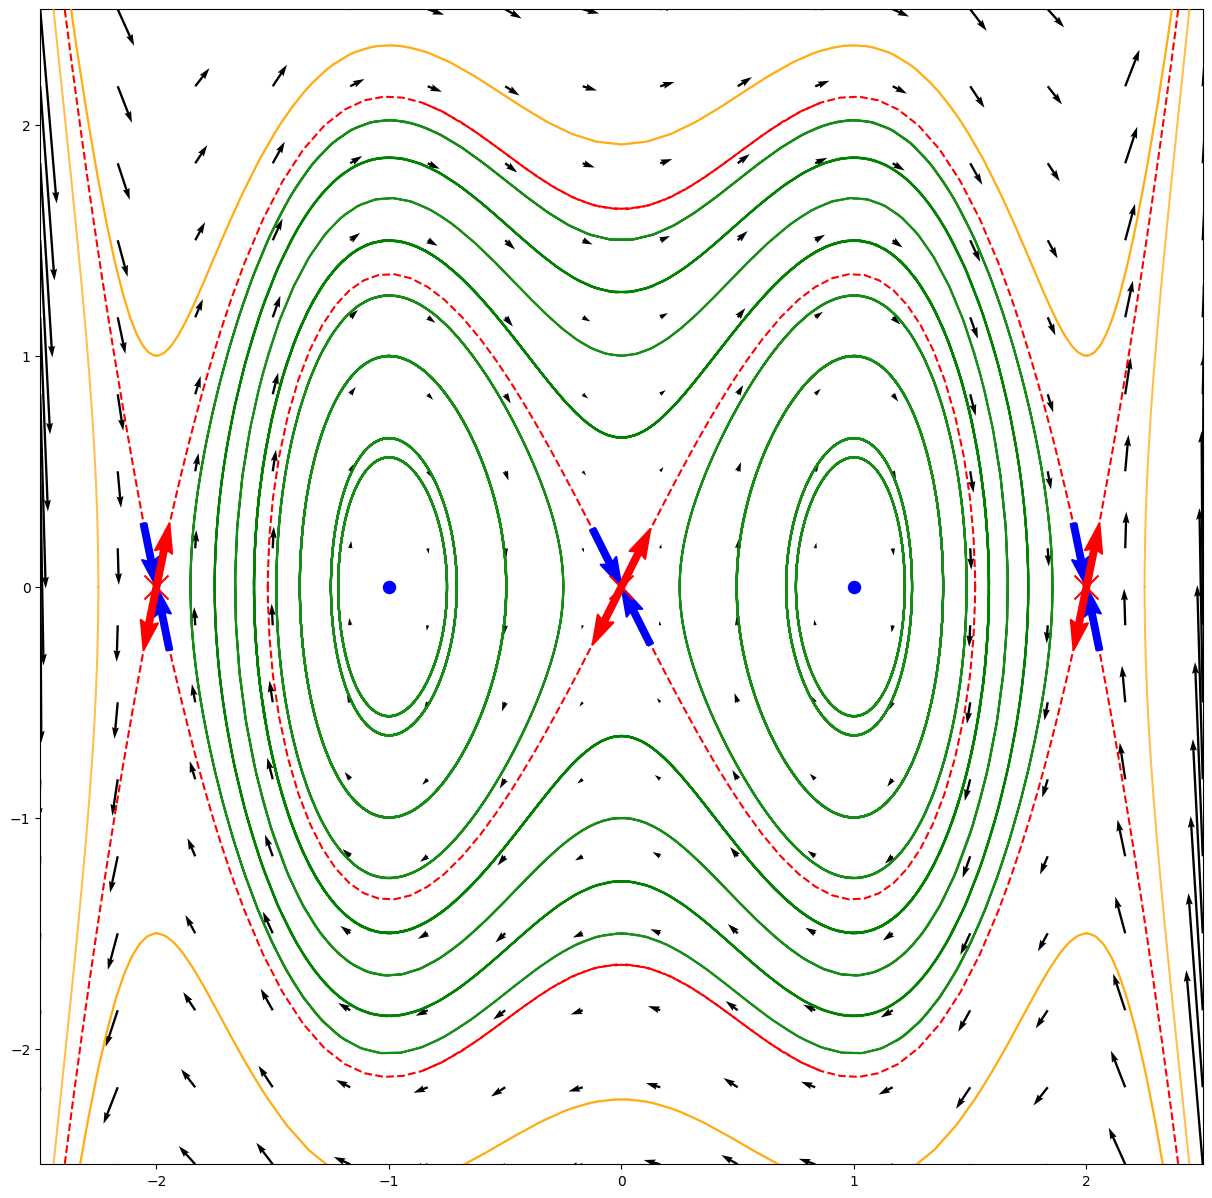

In [43]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
#alpha = -2*(pow(6,1/2))
alpha = 0
coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")



Замкнутые траектории:


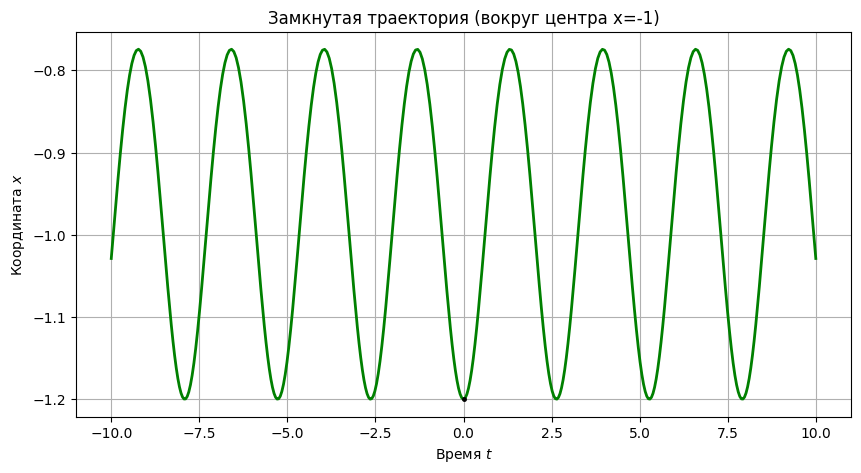

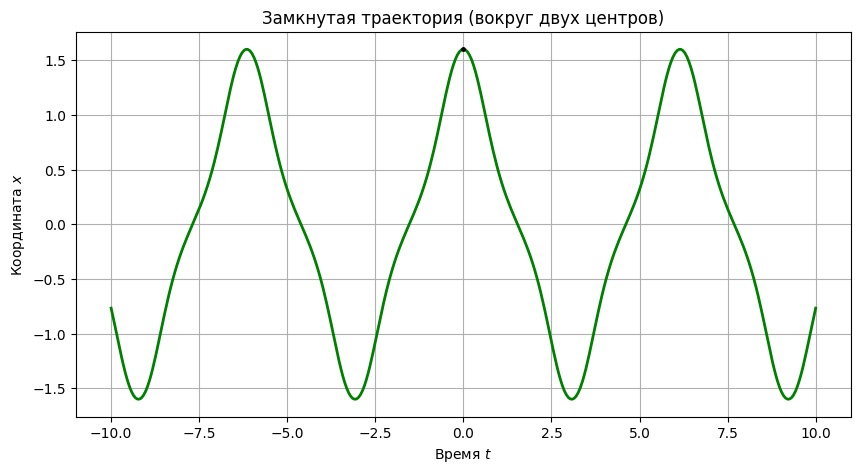

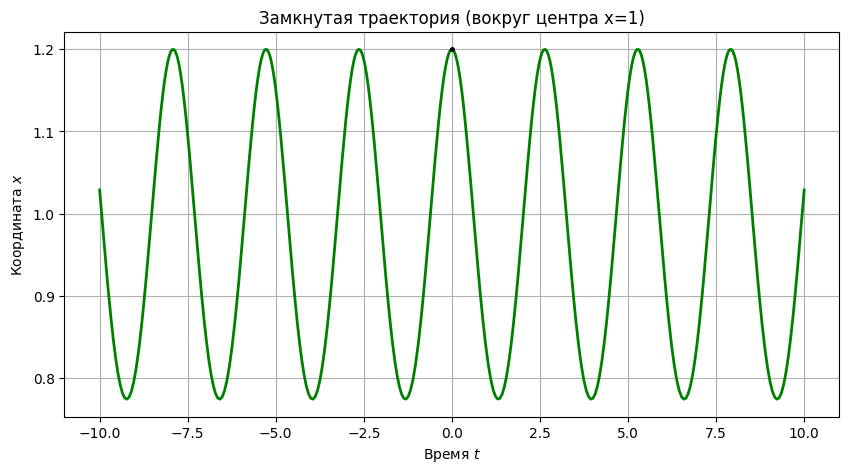

In [44]:
# замкнутые траектории
print ('Замкнутые траектории:')
X0 = [-1.2, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг центра x=-1)',
    color='green'
)
X0 = [1.6, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг двух центров)',
    color='green'
)
X0 = [1.2, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг центра x=1)',
    color='green'
)

Состояния равновесия


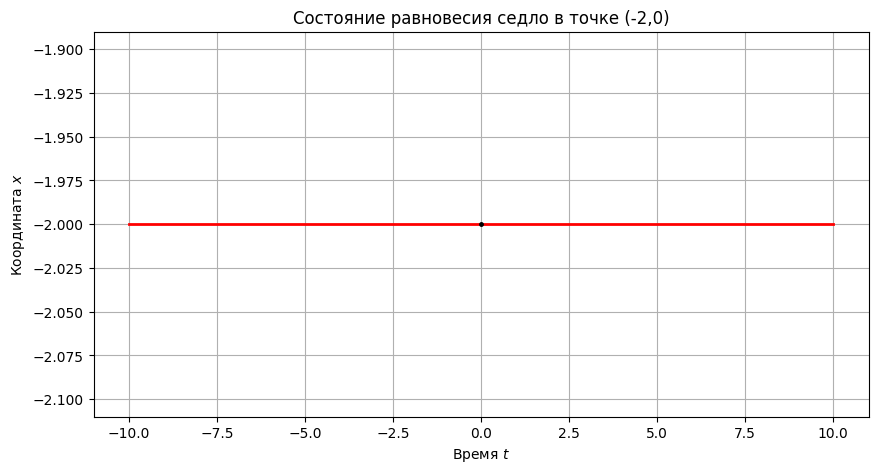

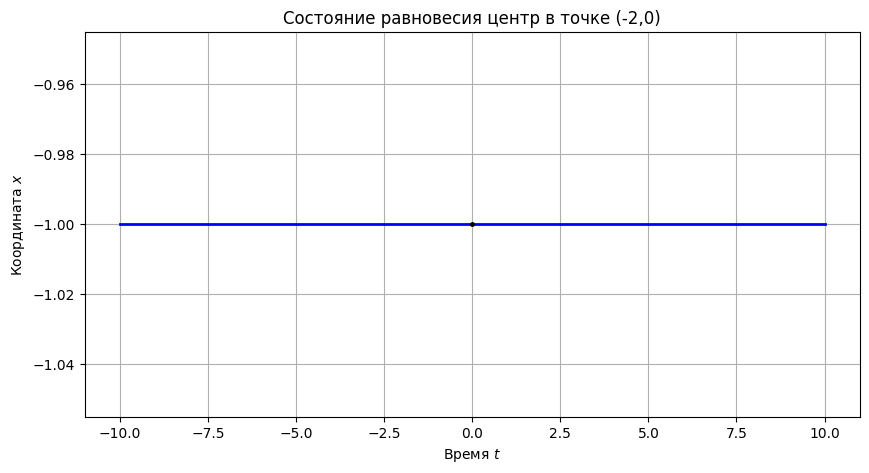

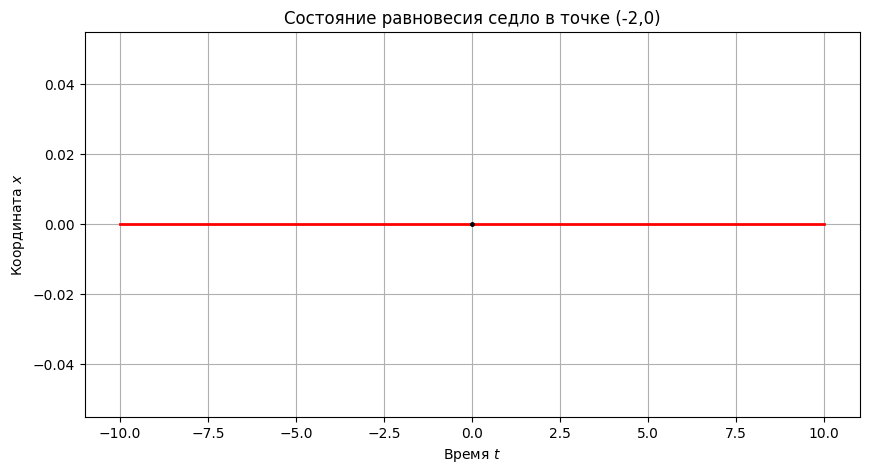

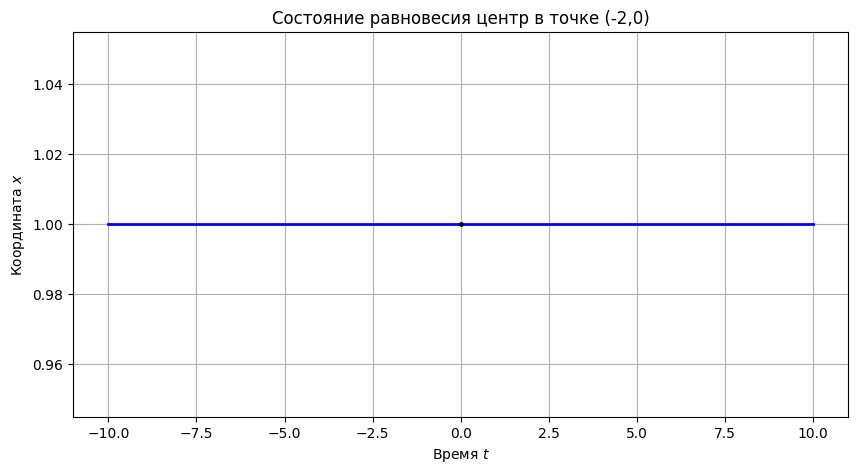

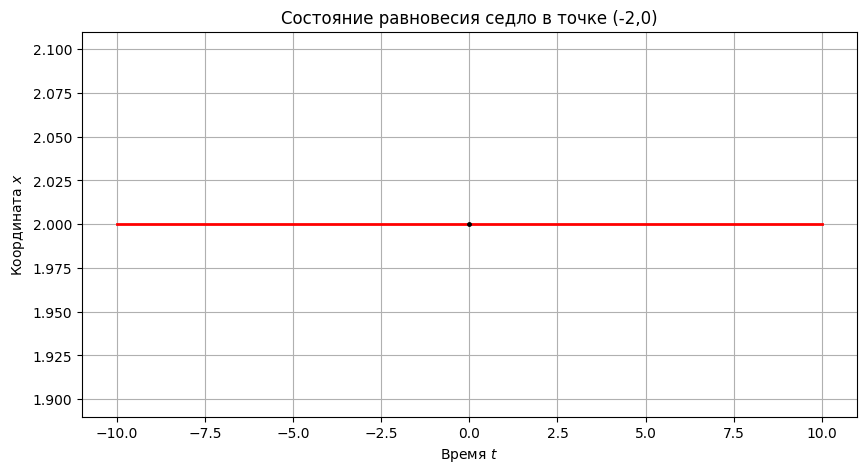

In [45]:
# состояния равновесия
print('Состояния равновесия')

for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    X0 = [x0,0.0]
    if type_number in {3, 4, 5, 6}:
        color_type = 'red'
    else:
        color_type = 'blue'
    plot_single_xt_realization(
        rhs=rhs,
        X0=X0,
        description=f'Состояние равновесия {type_name} в точке (-2,0)',
        color=color_type
    )



Лимитационно-инфинитные траектории


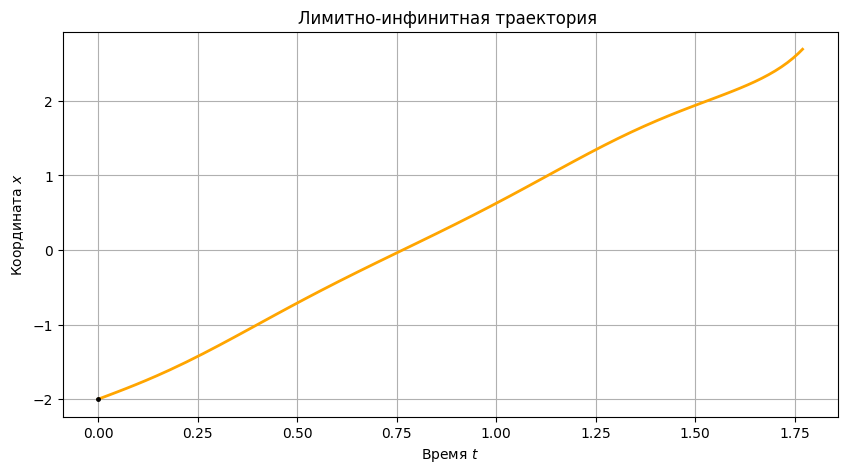

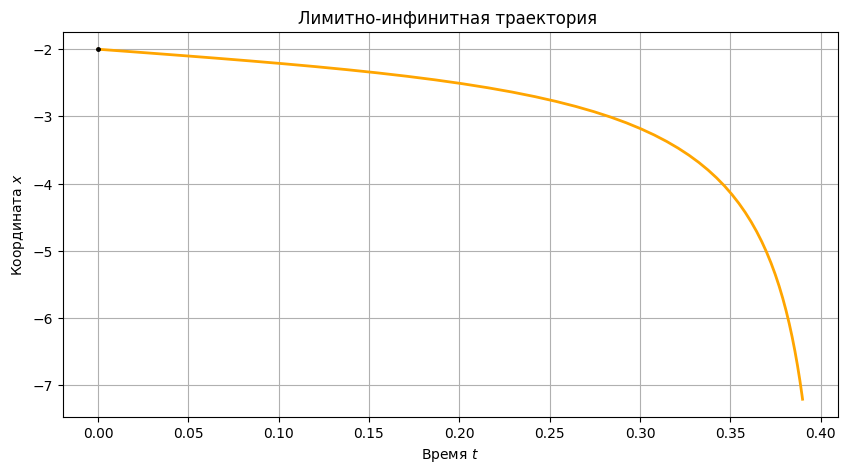

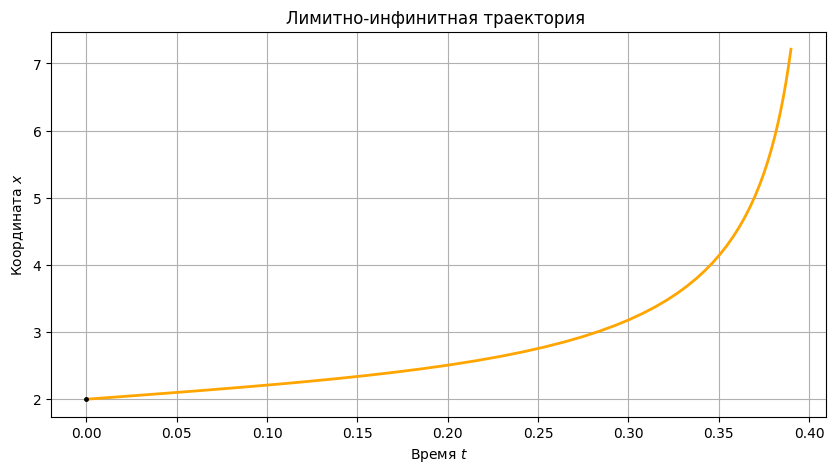

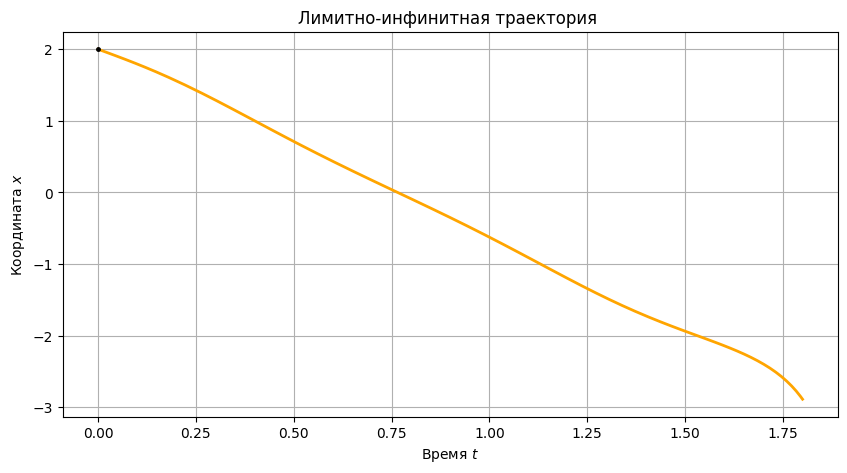

In [46]:
# лим инф
print('Лимитационно-инфинитные траектории')
X0 = [-2., 2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,1.77],
    color='orange'
)

X0 = [-2., -2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,0.39],
    color='orange'
)

X0 = [2., 2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,0.39],
    color='orange'
)

X0 = [2., -2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,1.8],
    color='orange'
)

Инфинитные траектории


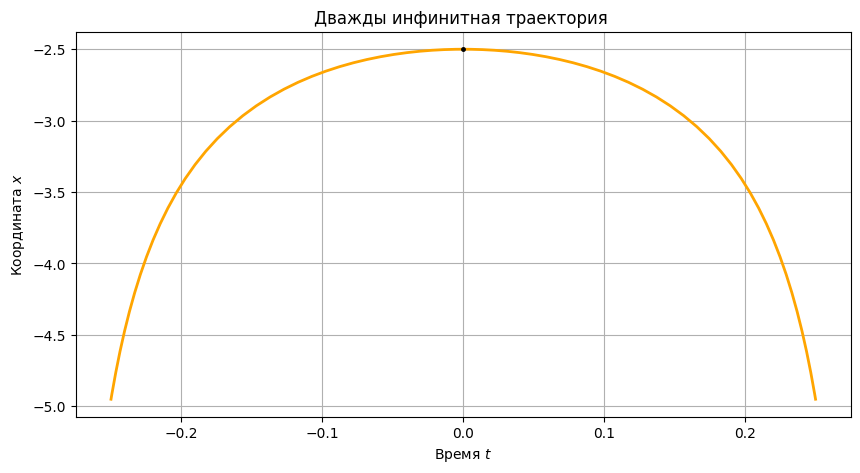

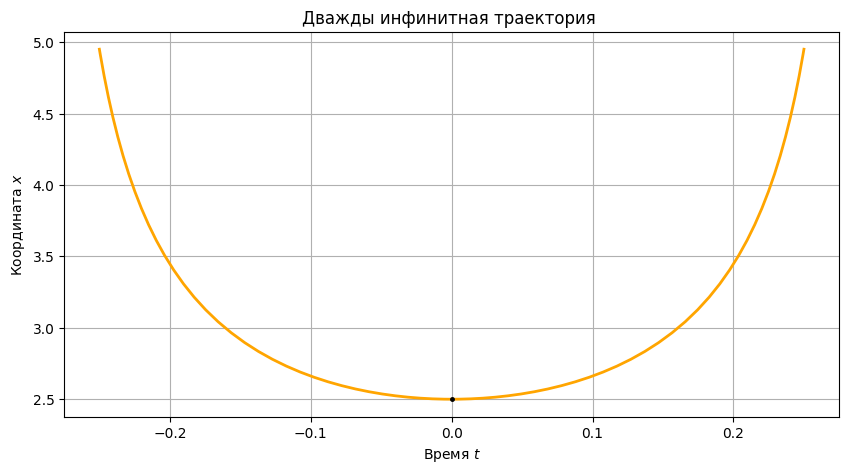

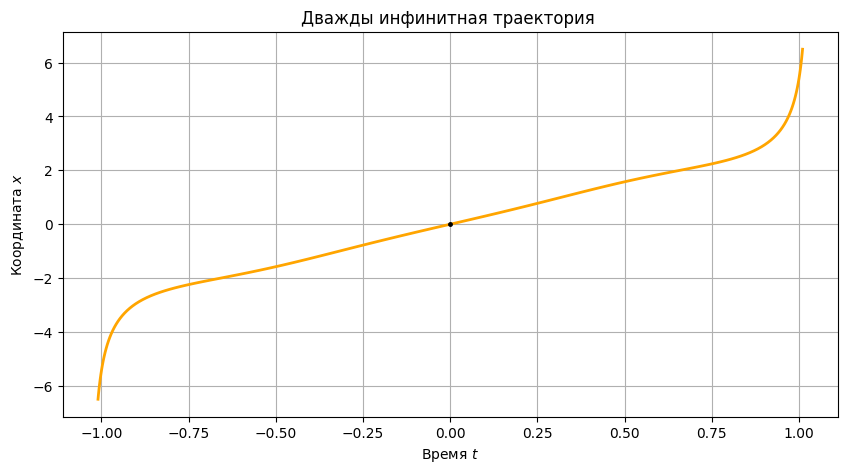

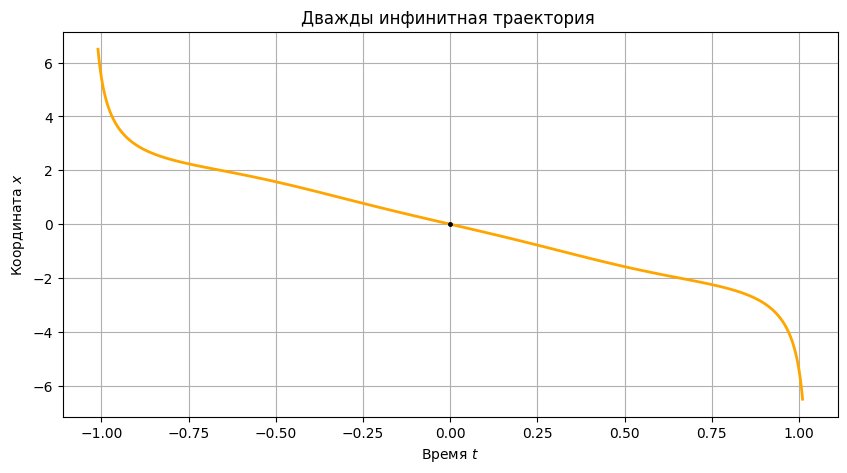

In [47]:
# дважды инф
print('Инфинитные траектории')
X0 = [-2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [0., 3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)

X0 = [0., -3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)


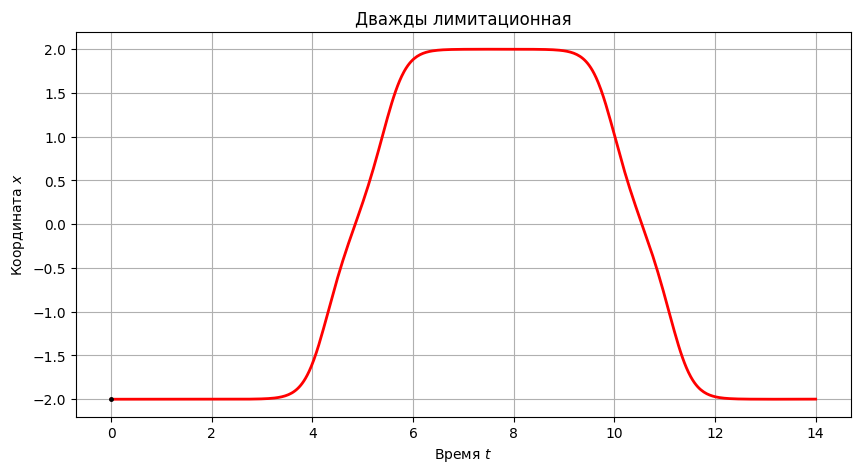

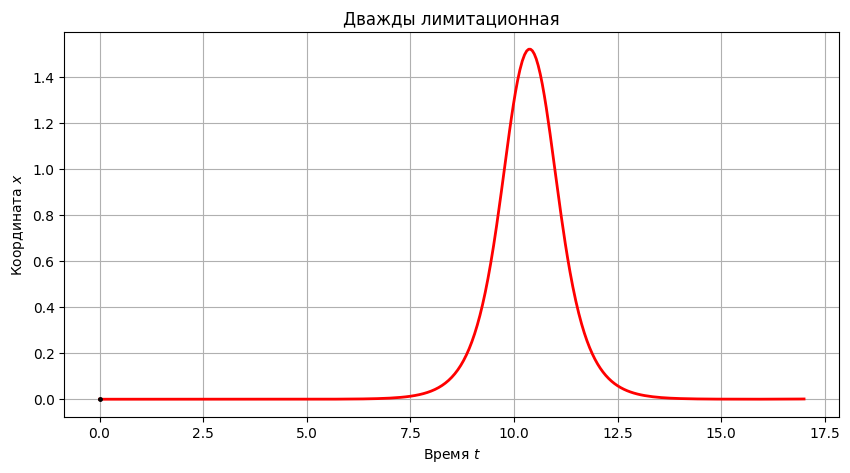

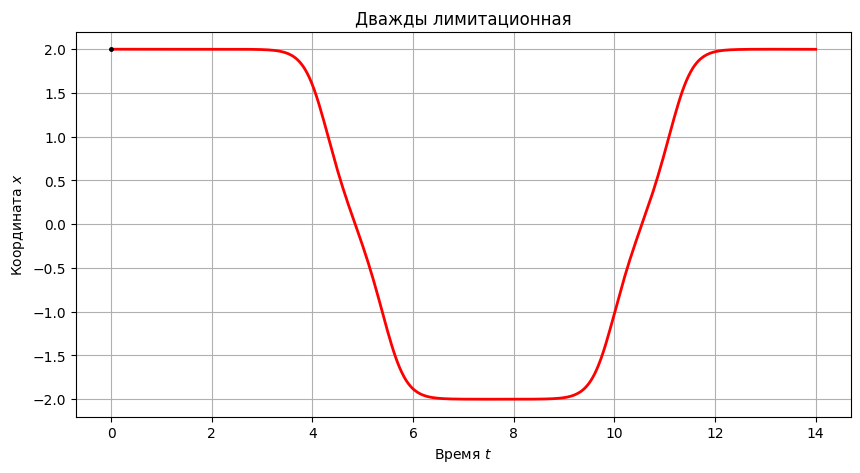

In [48]:
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)

x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 17],
    color='red'
)

x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)


[-2.  2. -1.  1.  0.]
alpha = -4.898979485566356
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [-3.02773583  7.92671532]
Собственные вектора = [[-0.31361704 -0.12516359]
 [ 0.94954955 -0.99213612]]
---------------------------
Точка P(-1.0, 0.0)
Тип: неустойчивый вырожденный узел
Собственные числа = [2.44948974+3.33200094e-08j 2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447+5.14138907e-09j -0.37796447-5.14138907e-09j]
 [-0.9258201 +0.00000000e+00j -0.9258201 -0.00000000e+00j]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [-0.71278792  5.6117674 ]
Собственные вектора = [[-0.81430994 -0.17543338]
 [ 0.58043029 -0.98449131]]
---------------------------
Точка P(1.0, 0.0)
Тип: неустойчивый вырожденный узел
Собственные числа = [2.44948974+3.33200094e-08j 2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447+5.14138907e-09j -0.37796447-5.14138907e-09j]
 [-0.9258201 +0.00000000

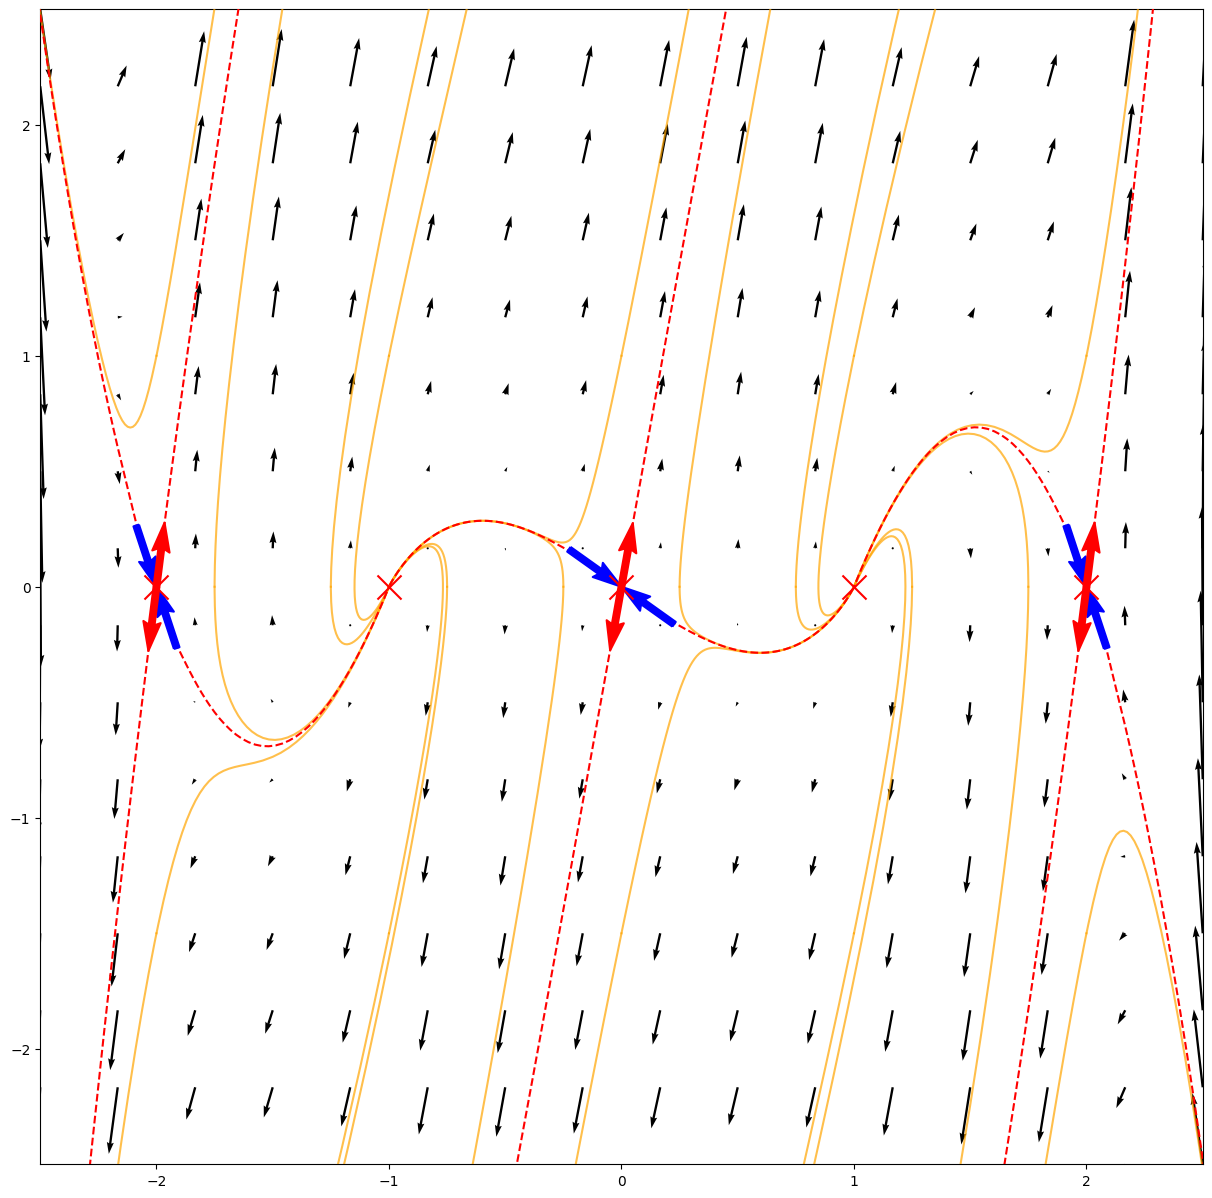

In [49]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = -2*(pow(6,1/2))

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

Состояния равновесия


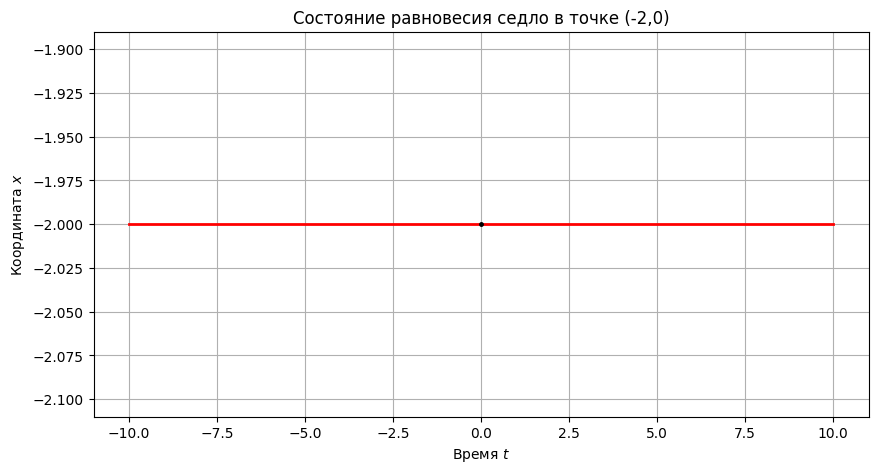

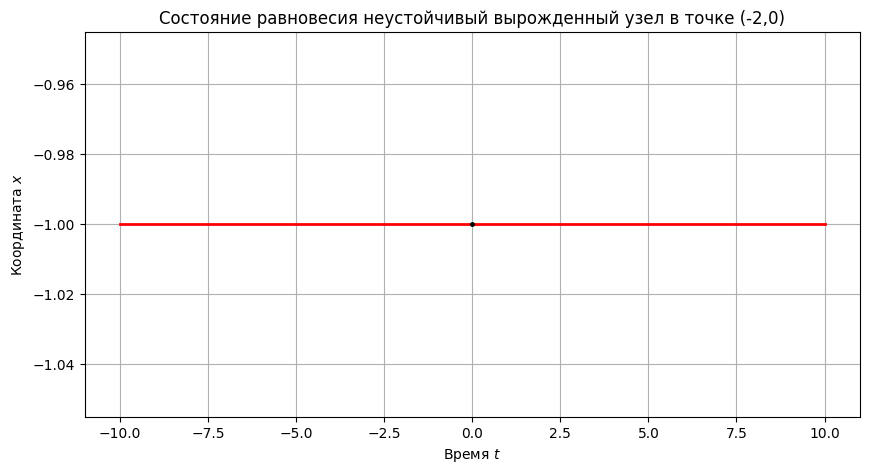

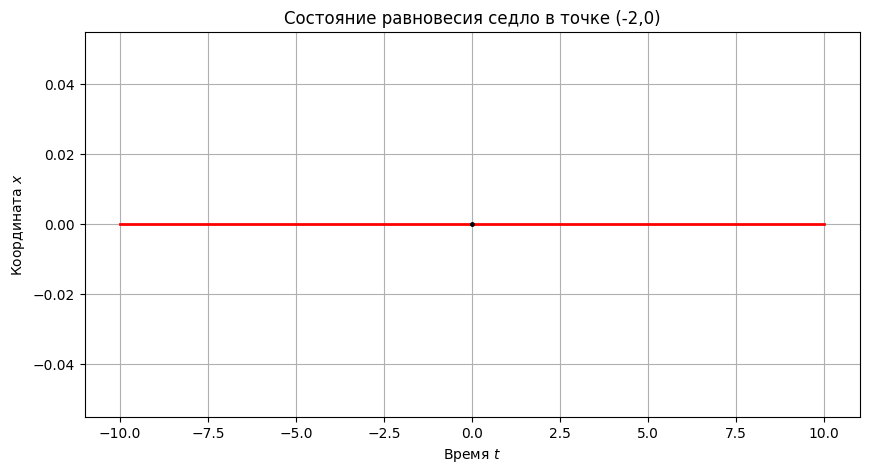

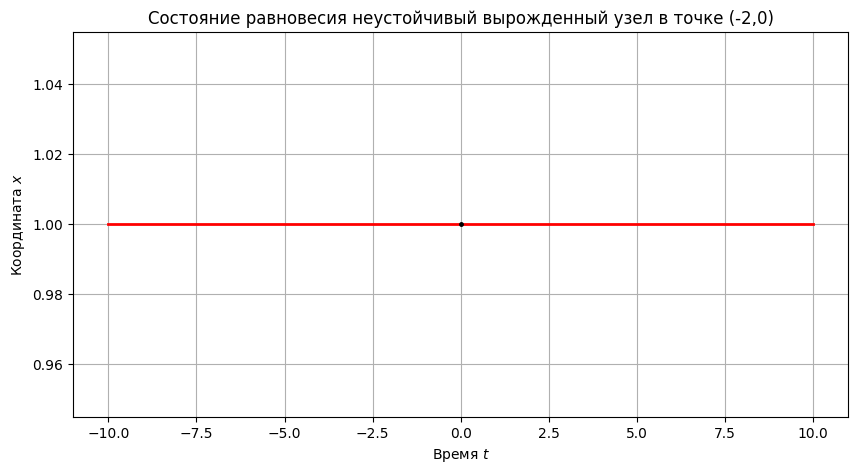

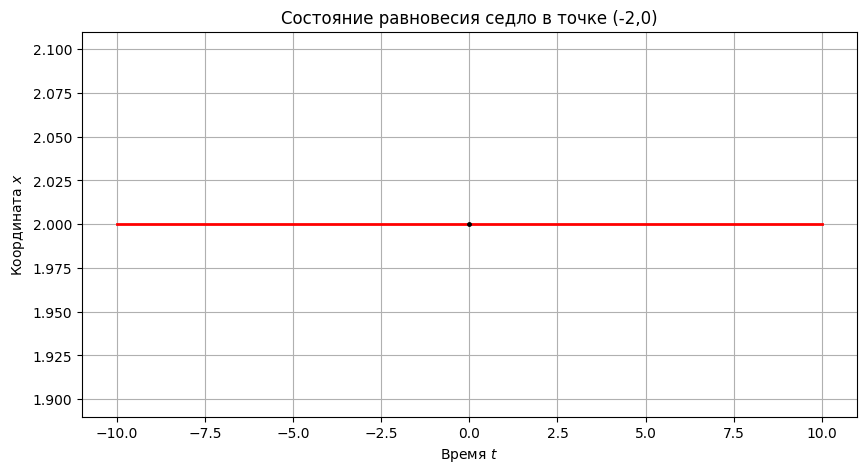

In [50]:
# состояния равновесия
print('Состояния равновесия')

for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    X0 = [x0,0.0]
    if type_number in {3, 4, 5, 6}:
        color_type = 'red'
    else:
        color_type = 'blue'
    plot_single_xt_realization(
        rhs=rhs,
        X0=X0,
        description=f'Состояние равновесия {type_name} в точке (-2,0)',
        color=color_type
    )


Лимитационно-инфинитные траектории


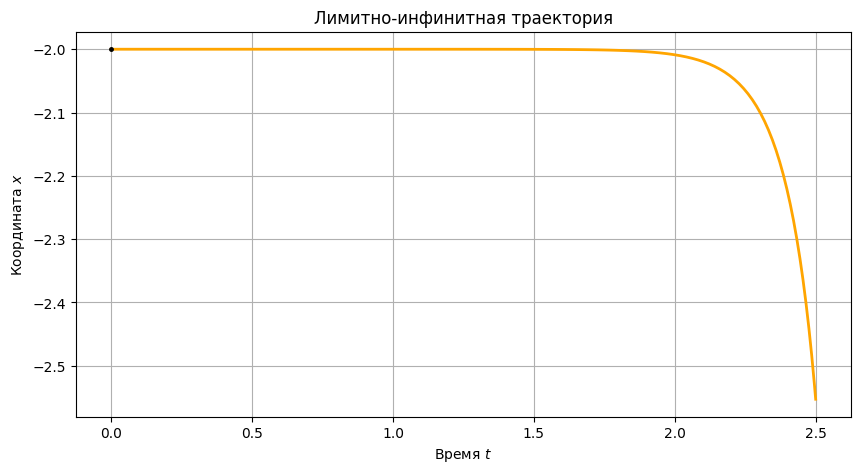

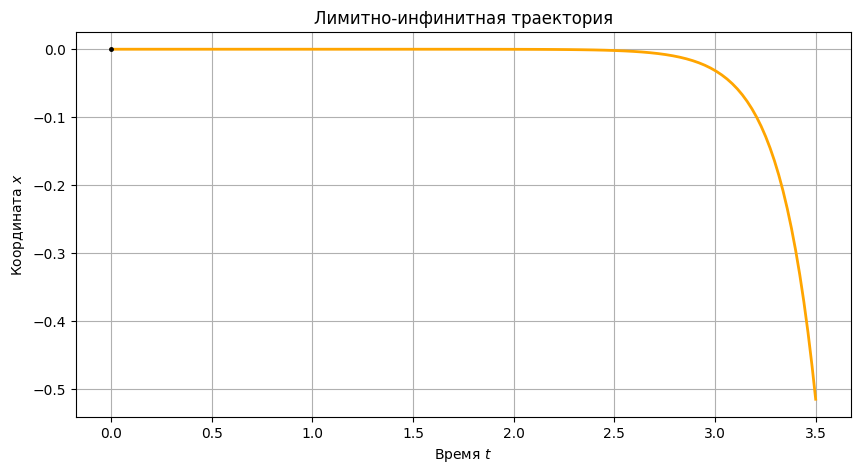

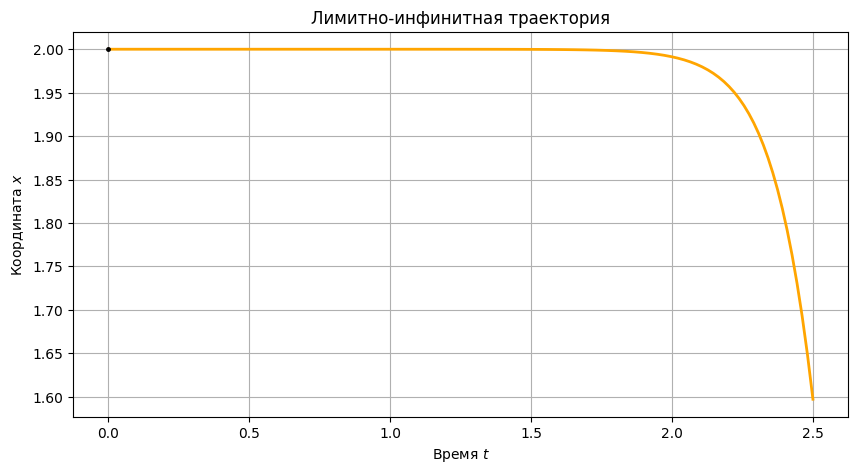

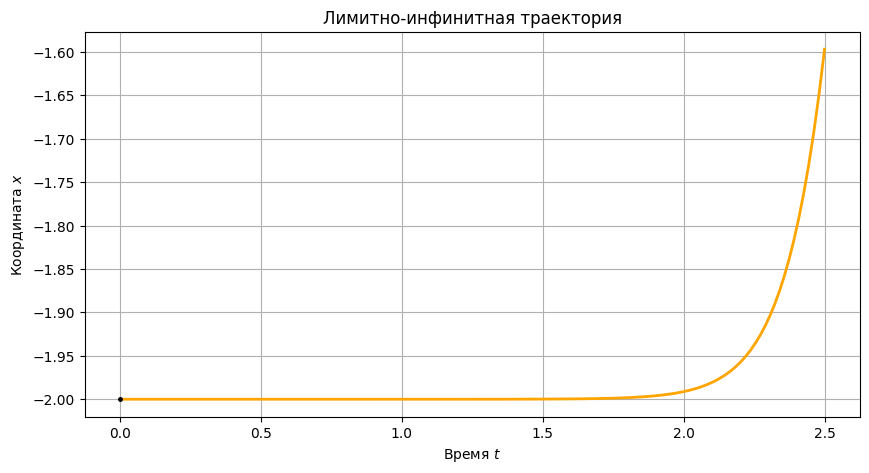

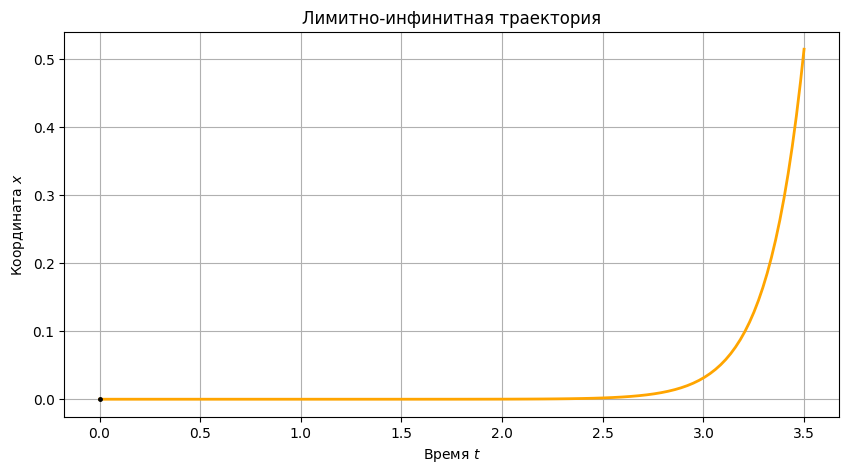

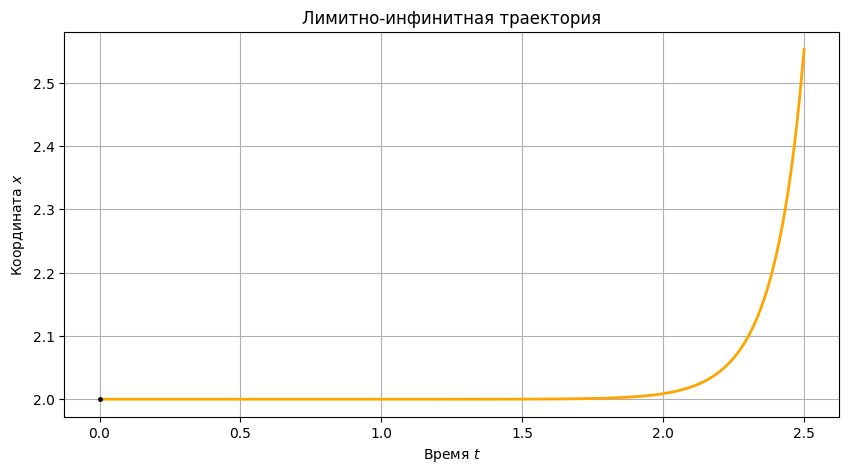

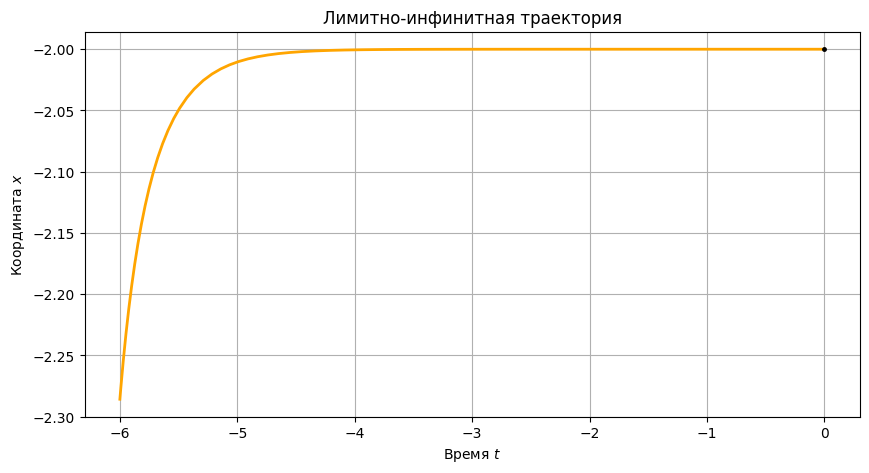

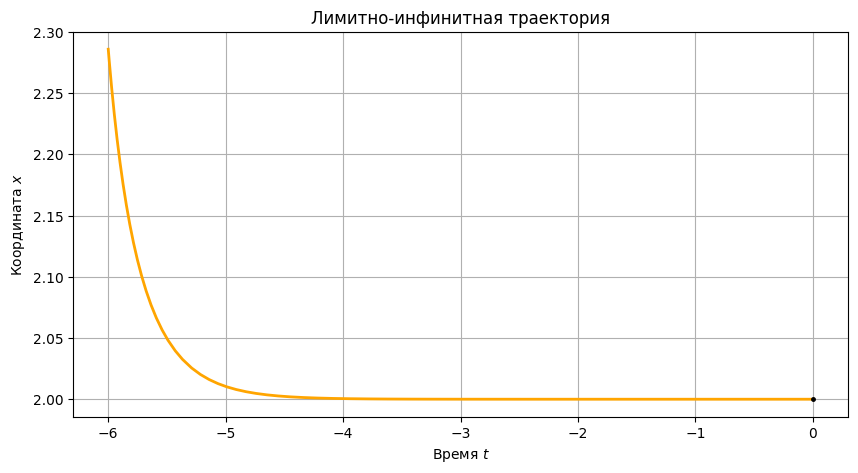

In [51]:
# лим инф
print('Лимитационно-инфинитные траектории')
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 3.5],
    color='orange'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 3.5],
    color='orange'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)

x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_s, # уст вектор
    description='Лимитно-инфинитная траектория',
    t_val=[-6., 0.],
    color='orange'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_s, # уст вектор
    description='Лимитно-инфинитная траектория',
    t_val=[-6., 0.],
    color='orange'
)




Инфинитные траектории


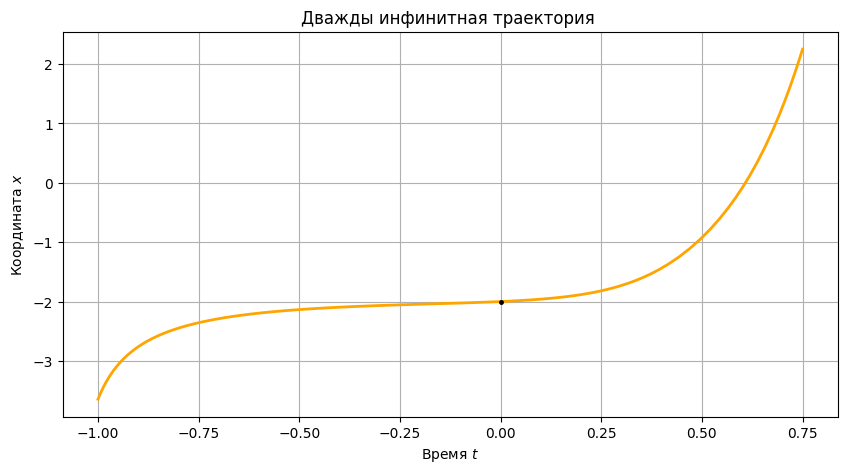

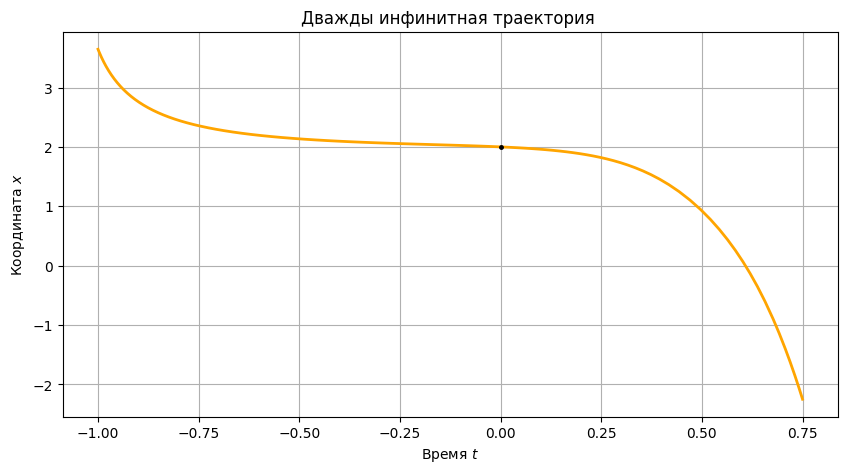

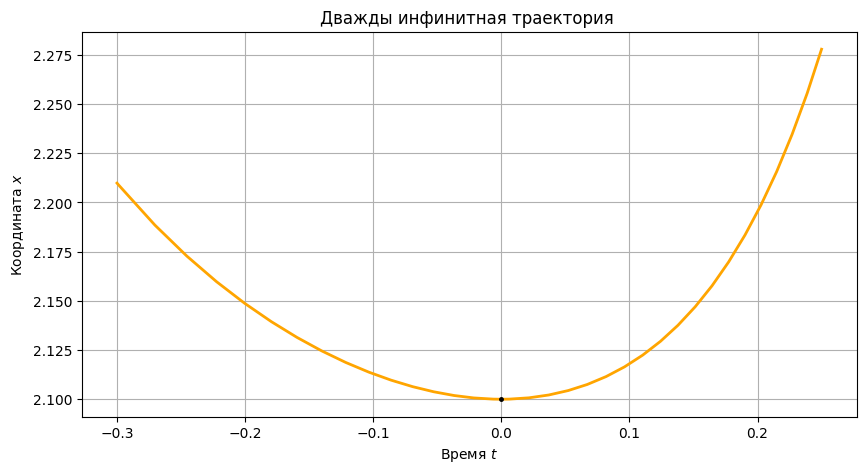

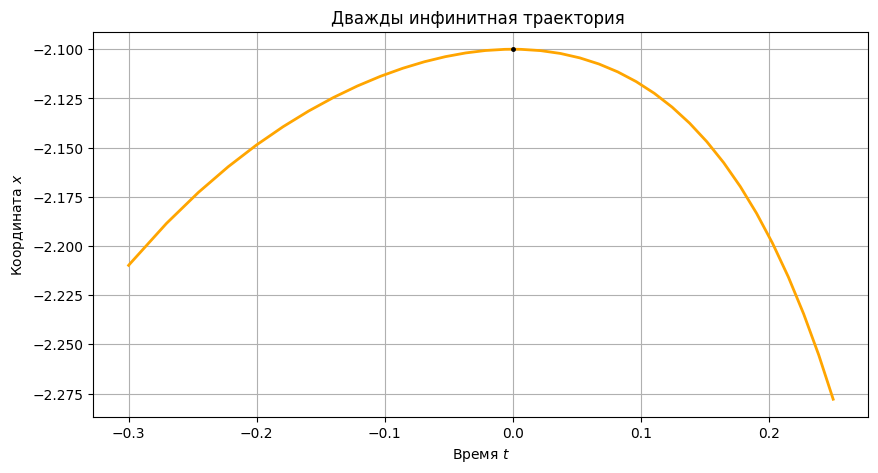

In [52]:
# дважды инф
print('Инфинитные траектории')
X0 = [-2., 0.3]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.,0.75],
    color='orange'
)

X0 = [2., -0.3]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.,0.75],
    color='orange'
)

X0 = [2.1, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.3,0.25],
    color='orange'
)

X0 = [-2.1, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.3,0.25],
    color='orange'
)



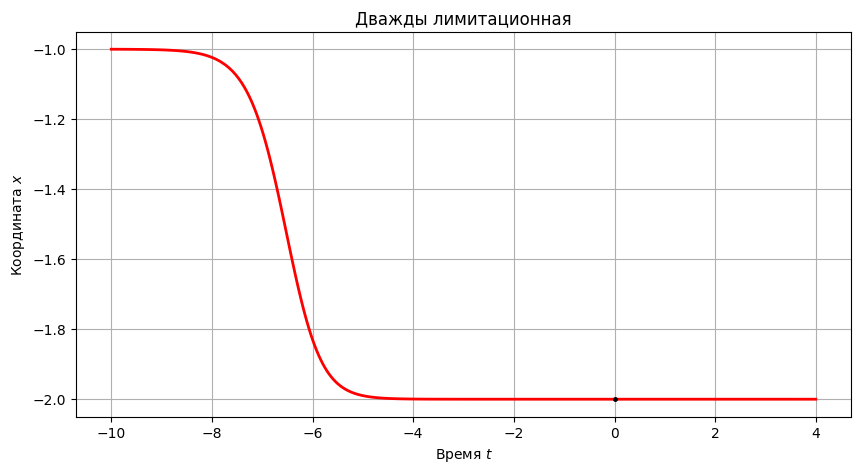

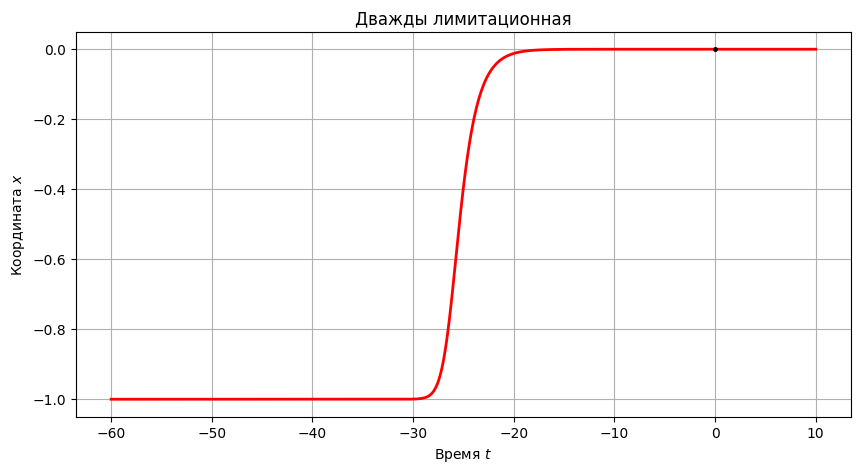

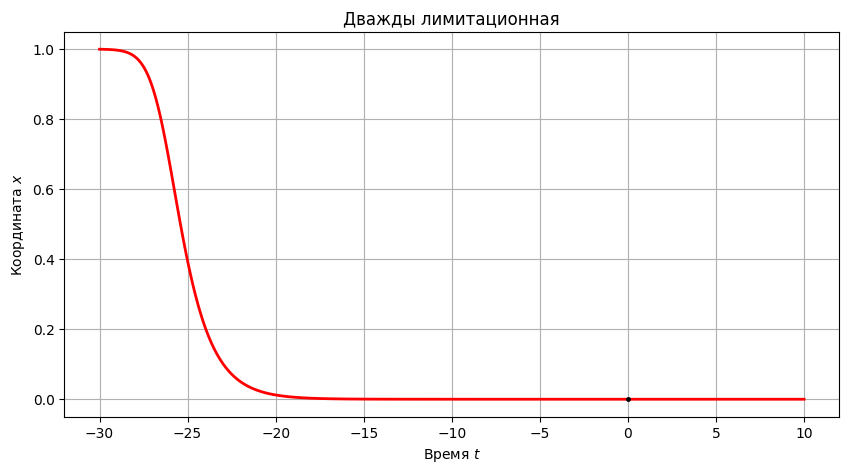

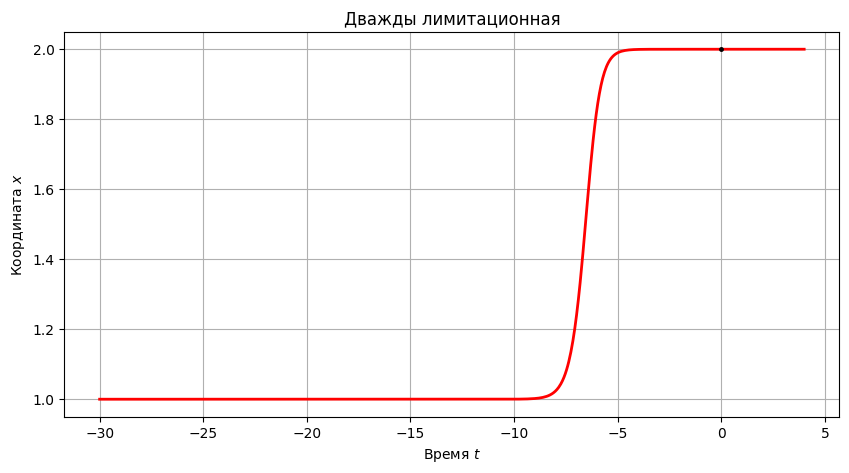

In [53]:
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_s, # Уст
    description='Дважды лимитационная',
    t_val=[-10, 4],
    color='red'
)

x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_s, # уст
    description='Дважды лимитационная',
    t_val=[-60, 10],
    color='red'
)

x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_s, # уст
    description='Дважды лимитационная',
    t_val=[-30, 10],
    color='red'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_s, # уст
    description='Дважды лимитационная',
    t_val=[-30, 4],
    color='red'
)


[-2.  2. -1.  1.  0.]
alpha = 4.898979485566356
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 3.02773583 -7.92671532]
Собственные вектора = [[ 0.31361704 -0.12516359]
 [ 0.94954955  0.99213612]]
---------------------------
Точка P(-1.0, 0.0)
Тип: устойчивый вырожденный узел
Собственные числа = [-2.44948974+3.33200094e-08j -2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447-5.14138907e-09j -0.37796447+5.14138907e-09j]
 [ 0.9258201 +0.00000000e+00j  0.9258201 -0.00000000e+00j]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 0.71278792 -5.6117674 ]
Собственные вектора = [[ 0.81430994 -0.17543338]
 [ 0.58043029  0.98449131]]
---------------------------
Точка P(1.0, 0.0)
Тип: устойчивый вырожденный узел
Собственные числа = [-2.44948974+3.33200094e-08j -2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447-5.14138907e-09j -0.37796447+5.14138907e-09j]
 [ 0.9258201 +0.00000000e

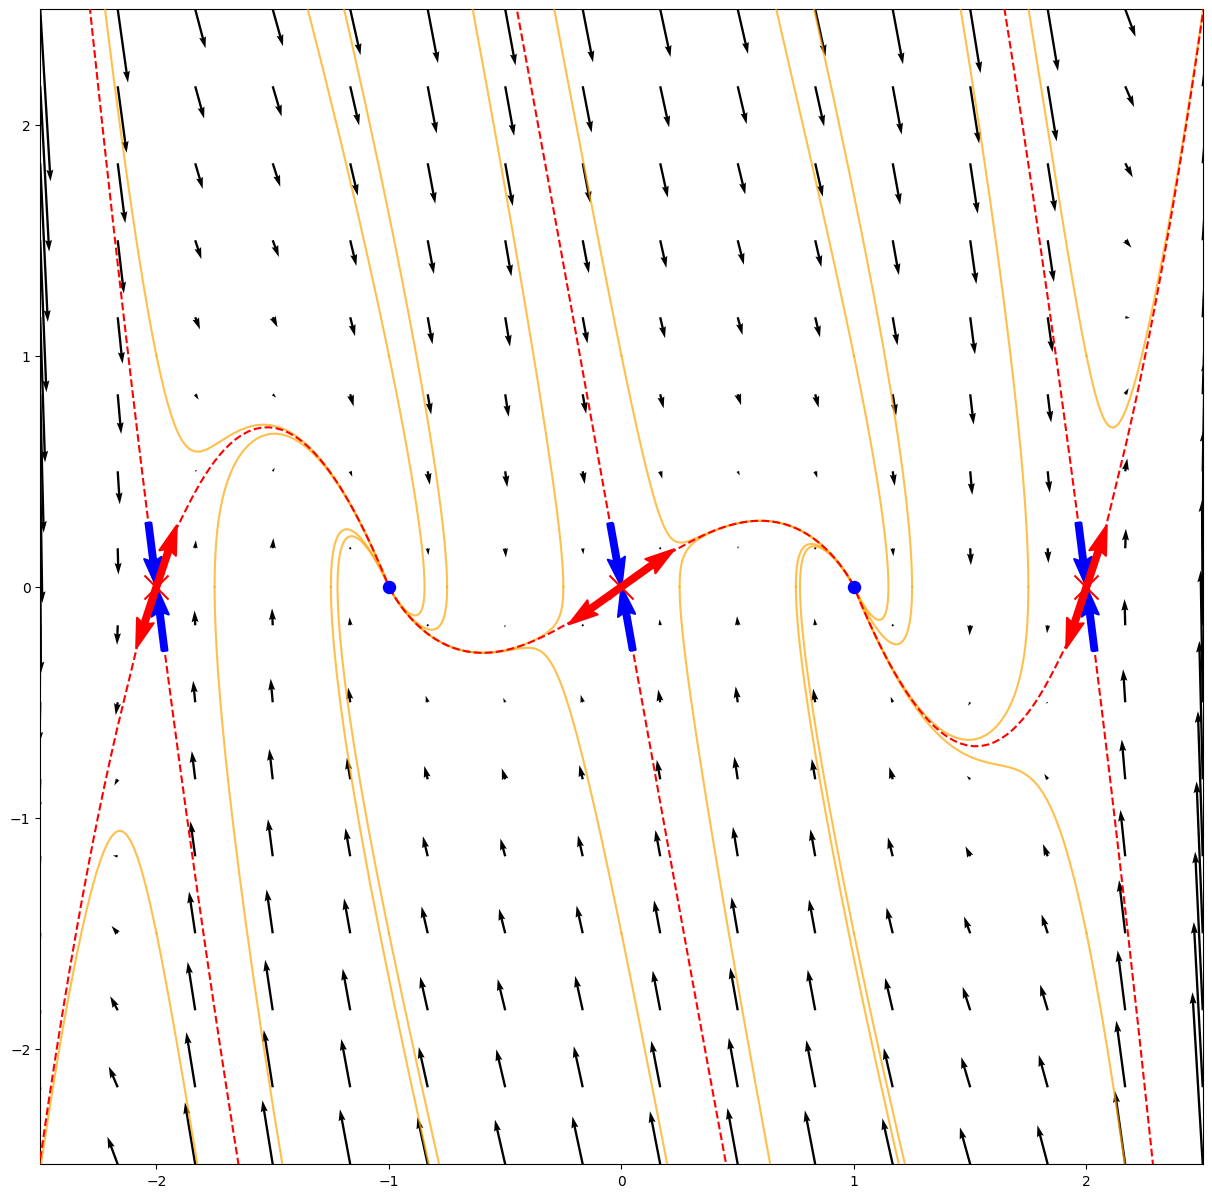

In [54]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )

alpha = 2*(pow(6,1/2))

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

[-2.  2. -1.  1.  0.]
alpha = -5
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [-3.  8.]
Собственные вектора = [[-0.31622777 -0.12403473]
 [ 0.9486833  -0.99227788]]
---------------------------
Точка P(-1.0, 0.0)
Тип: неустойчивый узел
Собственные числа = [2. 3.]
Собственные вектора = [[-0.4472136  -0.31622777]
 [-0.89442719 -0.9486833 ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [-0.70156212  5.70156212]
Собственные вектора = [[-0.81863069 -0.17275355]
 [ 0.57432028 -0.98496508]]
---------------------------
Точка P(1.0, 0.0)
Тип: неустойчивый узел
Собственные числа = [2. 3.]
Собственные вектора = [[-0.4472136  -0.31622777]
 [-0.89442719 -0.9486833 ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [-3.  8.]
Собственные вектора = [[-0.31622777 -0.12403473]
 [ 0.9486833  -0.99227788]]
---------------------------


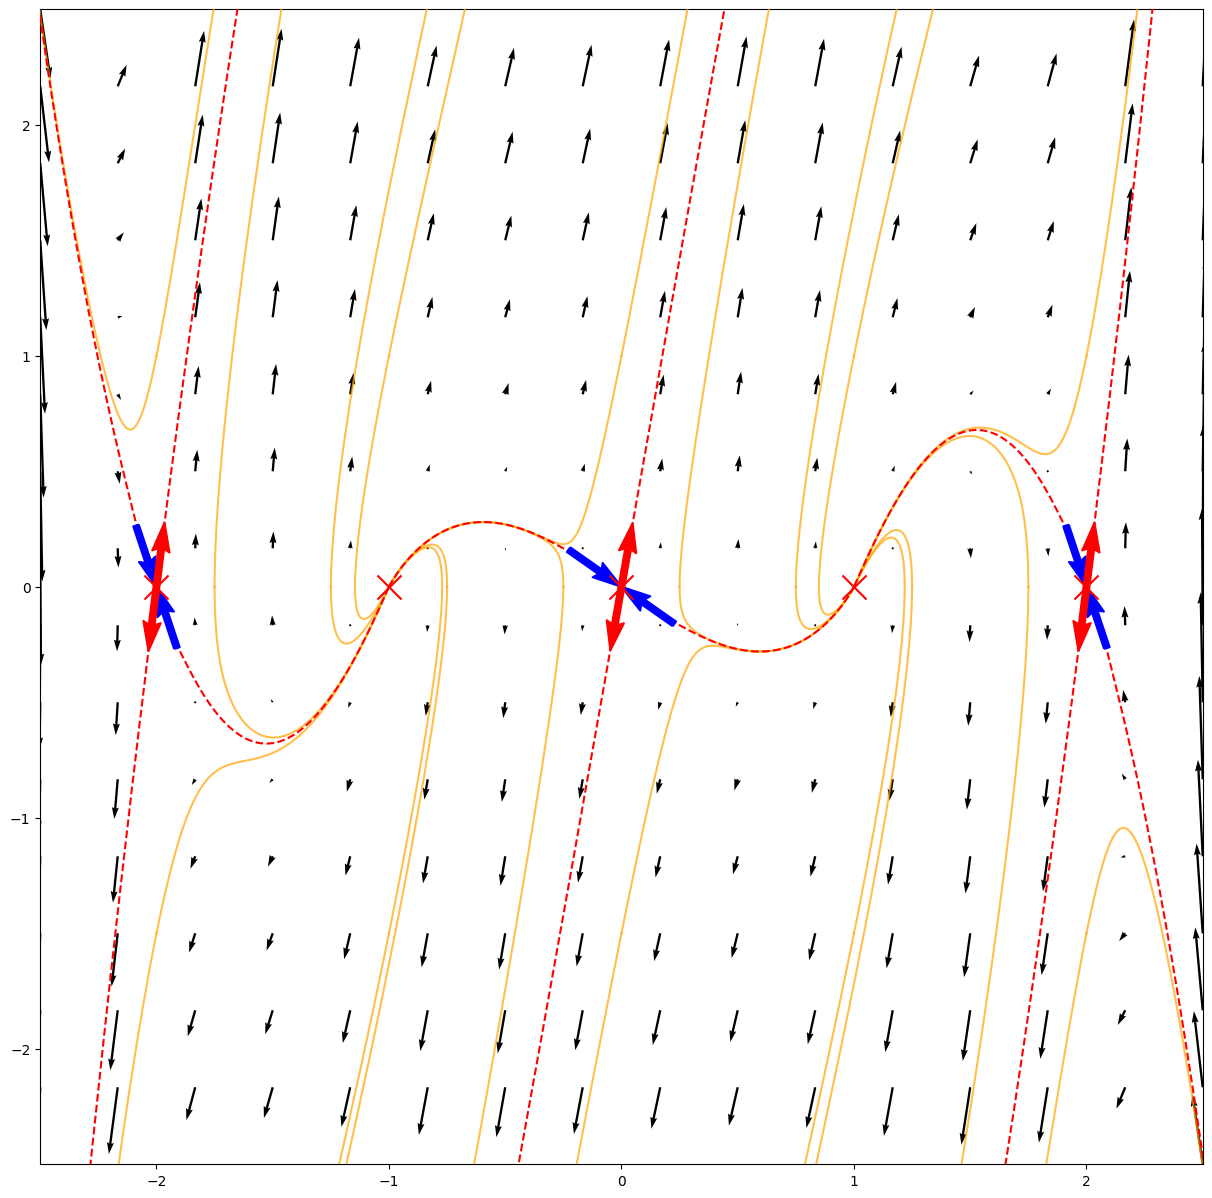

In [55]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = -5

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

[-2.  2. -1.  1.  0.]
alpha = 5
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 3. -8.]
Собственные вектора = [[ 0.31622777 -0.12403473]
 [ 0.9486833   0.99227788]]
---------------------------
Точка P(-1.0, 0.0)
Тип: устойчивый узел
Собственные числа = [-2. -3.]
Собственные вектора = [[ 0.4472136  -0.31622777]
 [-0.89442719  0.9486833 ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 0.70156212 -5.70156212]
Собственные вектора = [[ 0.81863069 -0.17275355]
 [ 0.57432028  0.98496508]]
---------------------------
Точка P(1.0, 0.0)
Тип: устойчивый узел
Собственные числа = [-2. -3.]
Собственные вектора = [[ 0.4472136  -0.31622777]
 [-0.89442719  0.9486833 ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [ 3. -8.]
Собственные вектора = [[ 0.31622777 -0.12403473]
 [ 0.9486833   0.99227788]]
---------------------------


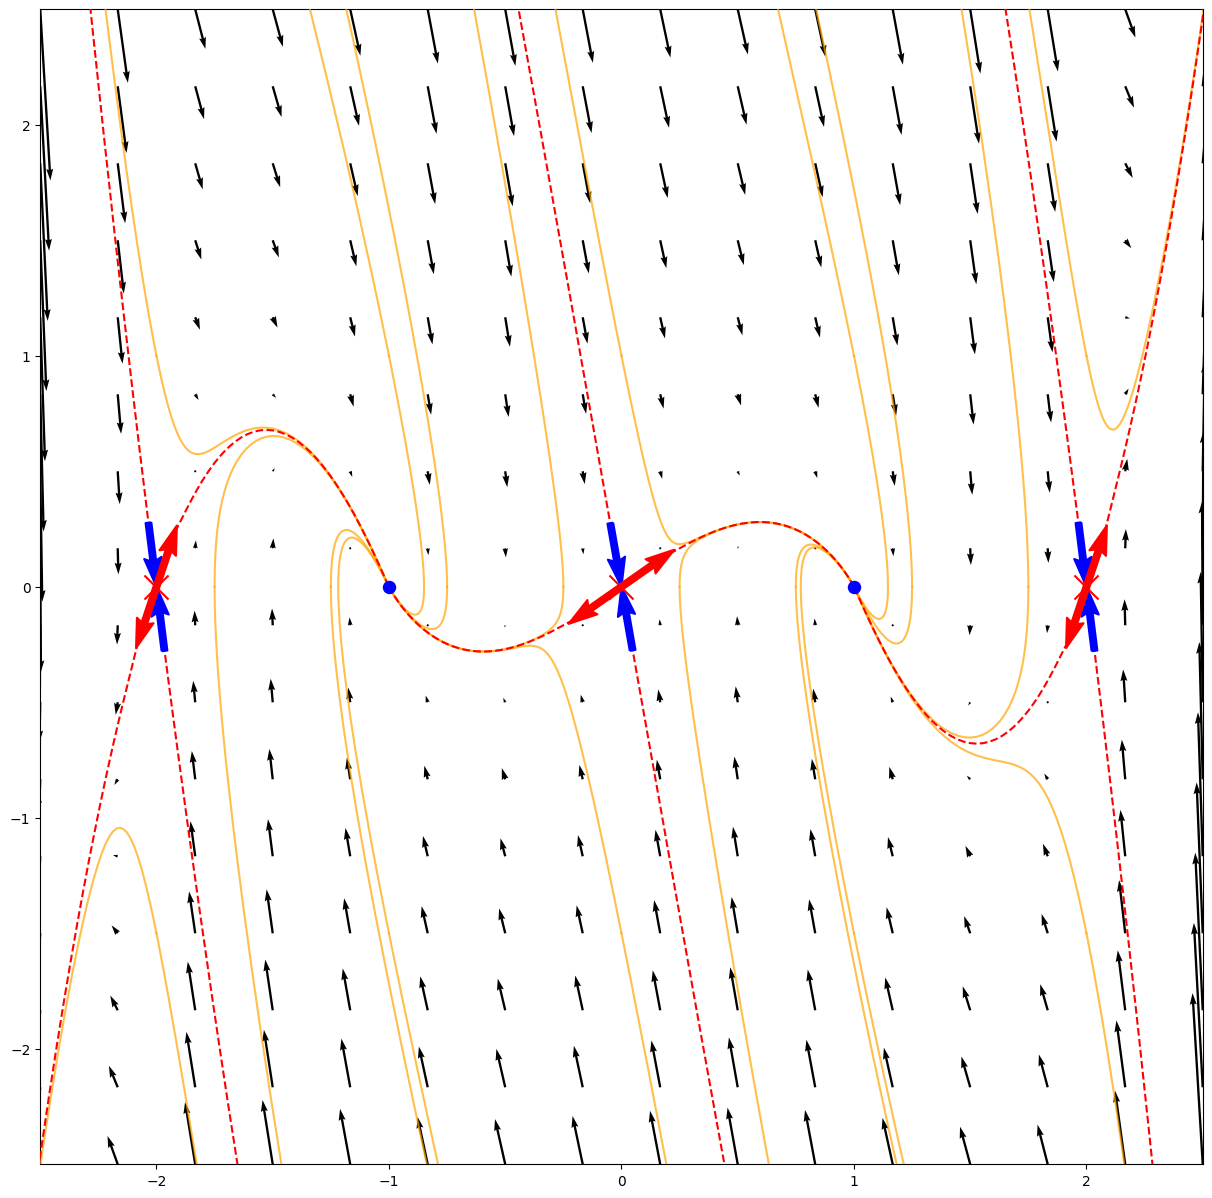

In [56]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = 5

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

In [57]:
import numpy as np # быстрые математические вычисления, работа с массивами
import matplotlib.pyplot as plt # рисует графики, поля, траектории
from scipy.integrate import solve_ivp
from sympy import symbols, diff, lambdify

In [58]:
def f1(alpha):  # тут вводим альфу
    def rhs(t, X):      # правая часть ДУ (Differential Equation Right-Hand Side)
        x, y = X        # X — это вектор состояния системы (x - координата, y - скорость)
        return [y, -alpha*y +pow(x,5) -5*pow(x,3)+4*x]  # возвращает dx/dt и dy/dt
    return rhs

# x' = y
# y' = x^5 - 5x^3 + 4x - alpha*y
#

In [59]:
# Функция для вычисления векторного поля
def vector_field_calculation(rhs, limits, N=16): #
    xs,ys = limits

    xs = np.linspace(xs[0],xs[1],N) # генерируем сетку равномерно распределенных чисел в заданном интервале
    ys = np.linspace(ys[0],ys[1],N)
    U, V = np.zeros((N,N)), np.zeros((N,N)) # переписываем в эти два массива нули (массивы скоростей)
        #U[i][j] будет хранить компоненту скорости по оси x
        #V[i][j] - компоненту скорости по оси у для точки с координатами (x[j], y[j]?)

    for i, y in enumerate (ys): # i получает индекс (0, 1, 2, ...). y[i] получает значение элемента.
            for j,x in enumerate (xs):
                u,v = rhs(0.0, [x,y])

                U[i][j] = u
                V[i][j] = v
            # проходим по всемм точкам сетки с координатами х у
            # вызываем функцию rhs(0.0, [x,y]), которая возвращает
            #вектор скорости в этой точке
            #значение компонент вектора u v сохраняются в массивы U V
    return xs,ys,U,V



In [60]:
#Функция для рисования векторного поля
def drawing_vector_field(rhs, limits):
    #plt.close() - можно раскоментить, но тогда придется перекинуть отрисовку сепаратрис пониже (...)
    xlims, ylims = limits # граница x граница y
    plt.xlim(xlims[0],xlims[1]) # задаем границы поля по x
    plt.ylim(ylims[0],ylims[1]) # задаем границы поля по y
    xs,ys,U,V = vector_field_calculation(rhs, limits) # Вызывает вспомогательную функцию vector_field_calculation. Эта функция рассчитывает координаты сетки (xs, ys) и компоненты векторов скоростей (U, V) для каждой точки сетки, используя правые части уравнений (rhs).
    plt.quiver(
        xs, ys, U, V, # Передает plt.quiver основные данные: (xs, ys) — начальные координаты каждой стрелки; (U, V) — X и Y компоненты (направление и длина) каждой стрелки.
        alpha=1, #Устанавливает прозрачность стрелок на 1.0 (полностью непрозрачные).

        width=0.002,      # Толщина стрелки (рекомендуется 0.001-0.005)
        headwidth=3,      # Ширина головки стрелки (стандартно ~3)
        headlength=5      # Длина головки стрелки (стандартно ~5)
    ) # plt.quiver рисует именно вектор из xs ys, в направлении



In [61]:
# поиск производной по функции
x = symbols('x')
f_x = x**5 - 5*x**3+4*x
df_dx = diff(f_x,x)
print(df_dx)

5*x**4 - 15*x**2 + 4


In [62]:
#создаем якобиан по альфе и иксу
def create_jacobian(alpha, x_value):
    # x'' + 2(sigma)x' + (gamma)y = 0 из этого уравнения сделали системку:
    # x' = 0x + y
    # y' = (5x^4 -15x^2 + 4)*x + (-alpha)*y
    #return np.array([[0, 1],[5*pow(x,4)-15*pow(x,2)+4, -alpha]])
    x = symbols('x')
    f_x = x**5 - 5*x**3+4*x
    df_dx = diff(f_x,x)
    df_dx_val = df_dx.subs(x,x_value)
    #print(type(df_dx_val))
    J = np.array([[0, 1],[df_dx_val, -alpha]], dtype=np.float64)
    return J

In [63]:
#считаем собственные числа и вектора
def solve_eigenvalues_and_jacobian(alpha,x):
    J = create_jacobian(alpha,x)
    # Вычисление собственных чисел и векторов
    eigenvalues, eigenvectors = np.linalg.eig(J)
    return eigenvalues, eigenvectors
    # eigenvalues - массив содержащий собственные числа (lambda1, lambda2)
    # eigenvectors - массив содержащий соответствующие собственные векторы

In [64]:
# пределяет тип состояния равновесия по текущим собственным числам
def stability_type(eigenvalues): # получает значения собственных чисел
    lambda_1 = eigenvalues[0] # первое собственное число
    lambda_2 = eigenvalues[1] # второе собственное число
    r1, r2 = lambda_1.real, lambda_2.real
    i1, i2 = lambda_1.imag, lambda_2.imag

    # -------------------------
    # Оба отрицательные
    if r1 < 0 and r2 < 0:
        if abs(i1) > 1e-6 or abs(i2) > 1e-6:
            return "устойчивый фокус", 0
        else:
            if abs(lambda_1 - lambda_2) < 1e-6:
                return "устойчивый вырожденный узел", 1
            else:
                return "устойчивый узел", 2

    # Оба положительные
    if r1 > 0 and r2 > 0:
        if abs(i1) > 1e-6 or abs(i2) > 1e-6:
            return "неустойчивый фокус", 3
        else:
            if abs(lambda_1 - lambda_2) < 1e-6:
                return "неустойчивый вырожденный узел", 4
            else:
                return "неустойчивый узел", 5

    # Разного знака
    if (r1 > 0 and r2 < 0) or (r1 < 0 and r2 > 0):
        return "седло", 6

    # Один ноль, другой отрицательный → нейтральная устойчивость
    if (abs(r1) < 1e-6 and r2 < 0) or (abs(r2) < 1e-6 and r1 < 0):
        return "нейтральный узел", 7

    # Один ноль, другой положительный → неустойчивость
    if (abs(r1) < 1e-6 and r2 > 0) or (abs(r2) < 1e-6 and r1 > 0):
        return "нейтральное седло", 8

    # Чисто мнимые → центр
    if abs(r1) < 1e-6 and abs(r2) < 1e-6:
        if abs(i1 + i2) < 1e-6 and abs(i1) > 1e-6:
            return "центр", 9
        else:
            return "нулевые собственные числа", 10



In [65]:
#рисует сепаратрисы (или собственный вектор для устойчивого узла)
def _draw_quiver_pair(x0, y0, v, scale, color, invert=False, zorder=5):

    v = np.array(v, dtype=float) # Преобразует входной вектор v в массив numpy с типом данных float для обеспечения корректных расчетов.
    v /= np.linalg.norm(v) # # Нормализует вектор v. Это нужно для того, чтобы масштабирование осуществлялось только за счет параметра scale.
    start1 = np.array([x0, y0])
    start2 = np.array([x0, y0])
    dx1, dy1 = v[0] * scale, v[1] * scale
    dx2, dy2 = -v[0] * scale, -v[1] * scale
    if invert:
        # ... (логика для invert=True остается прежней)

        plt.quiver(
        [start1[0], start2[0]], [start1[1], start2[1]],
        [dx1, dx2], [dy1, dy2],

         # Устанавливает масштаб стрелок на 1. Это критично, поскольку длина стрелки уже задана через scale при расчете dx/dy.
        ec=color,         # Цвет пунктира берется из аргумента color
        lw=1.5,           # Устанавливает толщину линии контура стрелки.
        fc=color, #Устанавливает цвет заливки (внутренней части) стрелки, используя входной аргумент color.
        width=0.005,
        headwidth=3,
        headlength=5,
        zorder=zorder,
        pivot="tip"
        # Дополнительные параметры: width — общая ширина тела стрелки; headwidth/headlength — размеры головки; zorder — порядок наложения (чтобы стрелки были поверх траекторий).
    )
        # Начальные точки start1 и start2 устанавливаются вдали от (x0,y0) на расстояние scale вдоль v и −v. Векторы сдвига dx/dy направлены К точке (x0,y0).
    else:
        # ... (логика для invert=False остается прежней)

        plt.quiver(
        [start1[0], start2[0]], [start1[1], start2[1]],
        [dx1, dx2], [dy1, dy2],
        ec=color,         # Цвет пунктира берется из аргумента color
        lw=1.5,           # Устанавливает толщину линии контура стрелки.
        fc=color, #Устанавливает цвет заливки (внутренней части) стрелки, используя входной аргумент color.
        width=0.005,
        headwidth=3,
        headlength=5,
        zorder=zorder,
        pivot="tail"
        # Дополнительные параметры: width — общая ширина тела стрелки; headwidth/headlength — размеры головки; zorder — порядок наложения (чтобы стрелки были поверх траекторий).
    )


In [66]:
# функция определяет какие сепаратрисы надо рисовать
def plot_eigendirections_arrows(eigenvalues, eigenvectors, stability_code,
                                equilibrium=(0, 0),
                                scale=1,
                                stable_color='b',    # стабильные синие
                                unstable_color='r',  # неустойчивые красные
                                ):
    """
    Отрисовывает собственные направления (сепаратрисы).
    Для седла — 2 (stable + unstable).
    """

    x0, y0 = equilibrium # Распаковывает координаты точки равновесия.
    l1, l2 = eigenvalues[0].real, eigenvalues[1].real # Извлекает действительные части собственных чисел. (Для седла важно только их знак.)
    v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1] # Извлекает собственные векторы v1 и v2, соответствующие собственным числам λ1 и λ2.

    # === СЕДЛО ===
    if stability_code == 6:
        if l1 < 0: # Если действительная часть первого собственного числа λ1 отрицательна (устойчива).
            # v1 — стабильное (к центру), v2 — неустойчивое (наружу)
            _draw_quiver_pair(x0, y0, v1, scale, stable_color, invert=True) #Устойчивая сепаратриса: Рисует стрелки вдоль v1. Используется stable_color (синий) и invert=True (стрелки К точке, так как направление устойчиво).
            _draw_quiver_pair(x0, y0, v2, scale, unstable_color, invert=False) #Неустойчивая сепаратриса: Рисует стрелки вдоль v2. Используется unstable_color (красный) и invert=False (стрелки ОТ точки, так как направление неустойчиво).
        else:
            _draw_quiver_pair(x0, y0, v2, scale, stable_color, invert=True)
            _draw_quiver_pair(x0, y0, v1, scale, unstable_color, invert=False)


In [67]:
# рисуем маркер состояния равновесия
def plot_equilibrium(stability, equilibrium=(0, 0)):
    x0, y0 = equilibrium
    marker = "."
    # Определяем цвет по коду
    if stability in [0, 1, 2, 9]:          # устойчивые
        color = 'b'
        marker="." # маркер точки)
    elif stability in [3, 4, 5, 6]:     # неустойчивые
        color = 'r'
        marker="x" # маркер крестика
    else: color = 'k'
    plt.scatter(x0, y0, s=300, c=color,marker = marker, zorder=6)


In [68]:
def draw_trajectories_around_point(rhs, x_eq, y_eq, stability_code, eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=20, offset=0.01):
    """
    Рисует локальные траектории вокруг точки равновесия (x_eq, y_eq).
    Для седла (stability_code=6) рисует 4 сепаратрисы с повышенной точностью.
    Для других типов рисует 3 общих траектории серым.
    """
    X_eq = np.array([x_eq, y_eq]) # Преобразуем координаты точки равновесия в массив NumPy.
    tochnost = 1e-8            # Устанавливаем увеличенную точность для решателя ДУ.

    # === 1. ЛОГИКА ДЛЯ СЕДЛА (Stability_code = 6) ===
    if stability_code == 6: # Проверяем, является ли точка седлом.

        if alpha==0: # Если параметр демпфирования равен нулю (консервативная система).
            t_max_sep = 1.8 # Устанавливаем короткое время интегрирования для сепаратрис (петля). чтобы они не наслаивались
        else: # Если альфа не равно нулю (диссипативная система).
            t_max_sep = 20 # Устанавливаем более длинное время интегрирования для сепаратрис.

        # Определяем устойчивые (stable, W^s) и неустойчивые (unstable, W^u) направления
        l1, l2 = eigenvalues[0].real, eigenvalues[1].real # Извлекаем действительные части собственных чисел.
        v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1] # Извлекаем соответствующие собственные векторы.

        # Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
        if l1 < 0: # Если первое собственное число отрицательное (устойчивое).
            v_s, v_u = v1, v2 # v1 — устойчивый вектор, v2 — неустойчивый.
        else: # Иначе (если l2 отрицательное).
            v_s, v_u = v2, v1 # v2 — устойчивый вектор, v1 — неустойчивый.

        # 1. Неустойчивые сепаратрисы (W^u): Интегрируем ВПЕРЕД
        initial_conditions_unstable = [ # Определяем две начальные точки вдоль неустойчивого вектора.
            X_eq + v_u * offset,   # Вдоль +v_u (немного отступаем от точки).
            X_eq - v_u * offset    # Вдоль -v_u.
        ]
        for X0 in initial_conditions_unstable: # Цикл по начальным условиям для неустойчивых сепаратрис.
            # Траектория УХОДИТ от седла (красный пунктир)
            sol = solve_ivp(rhs, [0, t_max_sep], X0, method='RK45', rtol=tochnost, atol=tochnost) # Интегрируем ВПЕРЕД по времени.
            plt.plot(sol.y[0], sol.y[1], color='red', linestyle='--', linewidth=1.5, zorder=4) # Рисуем траекторию красным пунктиром.

        # 2. Устойчивые сепаратрисы (W^s): Интегрируем НАЗАД
        initial_conditions_stable = [ # Определяем две начальные точки вдоль устойчивого вектора.
            X_eq + v_s * offset,   # Вдоль +v_s.
            X_eq - v_s * offset    # Вдоль -v_s.
        ]
        for X0 in initial_conditions_stable: # Цикл по начальным условиям для устойчивых сепаратрис.
            # Траектория ПРИХОДИТ в седло (красный пунктир)
            sol = solve_ivp(rhs, [0, -t_max_sep], X0, method='RK45', rtol=tochnost, atol=tochnost) # Интегрируем НАЗАД по времени.
            plt.plot(sol.y[0], sol.y[1], color='red', linestyle='--', linewidth=1.5, zorder=4) # Рисуем траекторию красным пунктиром.


    # === 2. ЛОГИКА ДЛЯ ВСЕХ ОСТАЛЬНЫХ ТОЧЕК ===

    # 3 общие начальные точки в окрестности (x_eq, y_eq)
    R_max = 10 # Устанавливаем максимальный радиус для оценки ограниченности траекторий (инфинитность).

    if stability_code == 6: # Если это седло, используем оранжевый цвет по умолчанию (хотя эти траектории обычно не рисуются).
        color = 'orange'
    else: # Для всех остальных типов точек (узлы, фокусы, центры) используем зеленый цвет по умолчанию.
        color = 'green'


    for X0_list in initial_conditions_general: # Цикл по общим начальным условиям.
        X0 = np.array(X0_list) # Преобразуем начальное условие в массив NumPy.
        # Функция для интегрирования и отрисовки
        def integrate_and_plot(t_span, default_color): # Вспомогательная функция для интегрирования и логики финитности/инфинитности.

            sol = solve_ivp(rhs, t_span, X0, method='RK45', rtol=tochnost, atol = tochnost) # Выполняем численное интегрирование.
            max_dist = np.max(np.linalg.norm(sol.y, axis=0)) # Вычисляем максимальное расстояние от начала координат.

            if max_dist > R_max: # Проверяем, вышла ли траектория за радиус
                plot_color = 'orange'  # Если инфинитная (ушла), помечаем зеленым.

            else: # Если траектория осталась ограниченной (финитной).
                if alpha==0: # Если система консервативная (alpha=0).
                    plot_color = 'green' # Помечаем финитные оранжевым
                else: # Если система диссипативная (alpha!=0).
                    plot_color = 'orange'  # Помечаем финитные зеленым


            plt.plot(sol.y[0], sol.y[1], color=plot_color, linestyle='-', # Рисуем полученную траекторию с определенным цветом.
                     linewidth=1.5, alpha=0.7, zorder=3)

        # Прямое направление (t > 0)
        integrate_and_plot([0, t_max], color) # Интегрируем вперед по времени.

        # Обратное направление (t < 0)
        integrate_and_plot([0, -t_max], color) # Интегрируем назад по времени.

In [69]:
def tochki_integrirovania(x_eq, y_eq, stable_type,alpha, offset=0.25):

    # Инициализация переменной для возврата
    initial_conditions_general = []

    # Принудительное преобразование stable_type в целое число для надежного сравнения
    if(alpha == -2*(pow(6,1/2))):
        initial_conditions_general = [
                [x_eq + offset*4, y_eq],
                [x_eq - offset*4, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6],
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq]
            ]
    if(alpha == 0):
        initial_conditions_general = [
                [x_eq + offset, y_eq],
                [x_eq - offset, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]
    if(alpha == 2*(pow(6,1/2))):
        initial_conditions_general = [
                [x_eq + offset*4, y_eq],
                [x_eq - offset*4, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6],
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq]
            ]
    if(alpha == 5):
        initial_conditions_general = [
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]
    if(alpha == -5):
        initial_conditions_general = [
                [x_eq + offset*3, y_eq],
                [x_eq - offset*3, y_eq],
                [x_eq, y_eq + offset * 4],
                [x_eq, y_eq - offset * 6]
            ]

    return initial_conditions_general

In [70]:
def plot_single_xt_realization(rhs, X0, description,
                               v_sep=None, # <-- Опциональный вектор сепаратрисы; по умолчанию None.
                               t_val=(-10, 10), tochnost=1e-8, # Интервал времени [t_min, t_max] и точность.
                               figsize=(10, 5), color='blue'): # Размер фигуры и цвет линии.
    """
    Универсальная функция для отрисовки временной реализации x(t).
    Интегрирует вперед и назад от X0.
    Если задан v_sep, X0 трактуется как точка равновесия, и начальная точка
    смещается от нее вдоль v_sep.
    """

    # === ЛОГИКА СМЕЩЕНИЯ ДЛЯ СЕПАРАТРИС ===
    # Проверяем, задан ли вектор сепаратрисы (активируем логику для седла)
    if v_sep is not None:

        v_sep = np.array(v_sep, dtype=float) # Преобразуем вектор в массив NumPy с типом float.

        # Нормализуем вектор (делаем его единичным)
        v_sep_norm = v_sep / np.linalg.norm(v_sep) # Вычисляем единичный вектор.

        # Смещаем начальную точку от седла (используем tochnost как offset)
        # В этом случае X0 воспринимается как точка равновесия (седло).
        X0 = np.array(X0) + v_sep_norm * 1e-8 # Вычисляем смещенную начальную точку.

    # Преобразуем X0 в numpy-массив для единообразия, если смещения не было
    else:
        X0 = np.array(X0, dtype=float) # Просто преобразуем переданное X0 в массив NumPy.


    # === ФУНКЦИЯ ОСТАНОВКИ ===
    #def stop_if_out_of_bounds(t, X): # Определяем функцию события для решателя ДУ.
    #    limit = 1000.0 # Устанавливаем предел, при превышении которого траектория считается инфинитной.
    #    return np.max(np.abs(X)) - limit # Событие наступает, когда max(|x|, |y|) = limit.
    #stop_if_out_of_bounds.terminal = True # Указываем решателю, что при наступлении события нужно остановить интегрирование.
    # ==========================

    # 1. Интегрирование ВПЕРЕД (t > 0)
    sol_forward = solve_ivp( # Вызываем решатель для положительного времени.
        rhs, [0, t_val[1]], X0, # Интервал [0, t_max].
        method='RK45', rtol=tochnost, atol=tochnost # Параметры точности и событие остановки.
    )

    # 2. Интегрирование НАЗАД (t < 0)
    sol_backward = solve_ivp( # Вызываем решатель для отрицательного времени.
        rhs, [0, t_val[0]], X0, # Интервал [0, t_min] (t_min будет отрицательным).
        method='RK45', rtol=tochnost, atol=tochnost # Параметры точности и событие остановки.
    )

    # 3. Объединение результатов
    # sol_backward.t это массив NumPy, содержащий значения времени t в точках, где решатель вычислил решение.
    # [start:stop:step], начинаем с начала, заканчиваем в конце, идем в обратном направлении с шагом 1 (от конца к началу)
    # [start:end:step] step = -1 => мы хотим двигаться справа налево
    t_back_rev = sol_backward.t[::-1] # Разворачиваем массив времени обратного интегрирования (от t_min к 0).
    x_back_rev = sol_backward.y[0][::-1] # Разворачиваем массив координаты x.
    #(.y[0]) содержит все значения координаты x(t).
    # [::-1] разворачивает этот массив, чтобы значения x шли в хронологическом порядке, соответствующем развёрнутому времени: от x(t_min) до x(0)


    # Исключаем t=0 из обратного интегрирования, чтобы избежать дублирования
    # функция, которая объединяет последовательность массивов (или кортежей) вдоль указанной оси, создавая один новый, более длинный массив.
    # [:-1] используется для исключения дублирующей точки t=0, которая присутствует в обоих массивах.
    t_full = np.concatenate((t_back_rev[:-1], sol_forward.t)) # Объединяем массивы времени, исключая последний элемент t=0 из t_back_rev.
    x_full = np.concatenate((x_back_rev[:-1], sol_forward.y[0])) # Объединяем массивы координаты x.


    # 4. Создание новой фигуры и отрисовка
    plt.figure(figsize=figsize) # Создаем новый график с заданным размером.
    plt.plot(t_full, x_full, color=color, linewidth=2) # Рисуем объединенную временную реализацию.

    # 5. Оформление
    # Отмечаем начальную точку, через которую прошла траектория
    plt.plot(0, X0[0], color = "black", marker = ".", markersize=5) # Отмечаем точку X0 (при t=0) черным кружком. 'ko'


    plt.title(f'{description}') # Устанавливаем заголовок графика.
    plt.xlabel('Время $t$') # Подписываем ось времени.
    plt.ylabel('Координата $x$') # Подписываем ось координаты.
    plt.grid(True) # Включаем сетку на графике.
    plt.show() # Показываем график.

[-2.  2. -1.  1.  0.]
alpha = 0
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 4.89897949 -4.89897949]
Собственные вектора = [[ 0.2       -0.2      ]
 [ 0.9797959  0.9797959]]
---------------------------
Точка P(-1.0, 0.0)
Тип: центр
Собственные числа = [0.+2.44948974j 0.-2.44948974j]
Собственные вектора = [[0.       -0.37796447j 0.       +0.37796447j]
 [0.9258201+0.j         0.9258201-0.j        ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 2. -2.]
Собственные вектора = [[ 0.4472136  -0.4472136 ]
 [ 0.89442719  0.89442719]]
---------------------------
Точка P(1.0, 0.0)
Тип: центр
Собственные числа = [0.+2.44948974j 0.-2.44948974j]
Собственные вектора = [[0.       -0.37796447j 0.       +0.37796447j]
 [0.9258201+0.j         0.9258201-0.j        ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [ 4.89897949 -4.89897949]
Собственные вектора = [[ 0.2       -0.2   

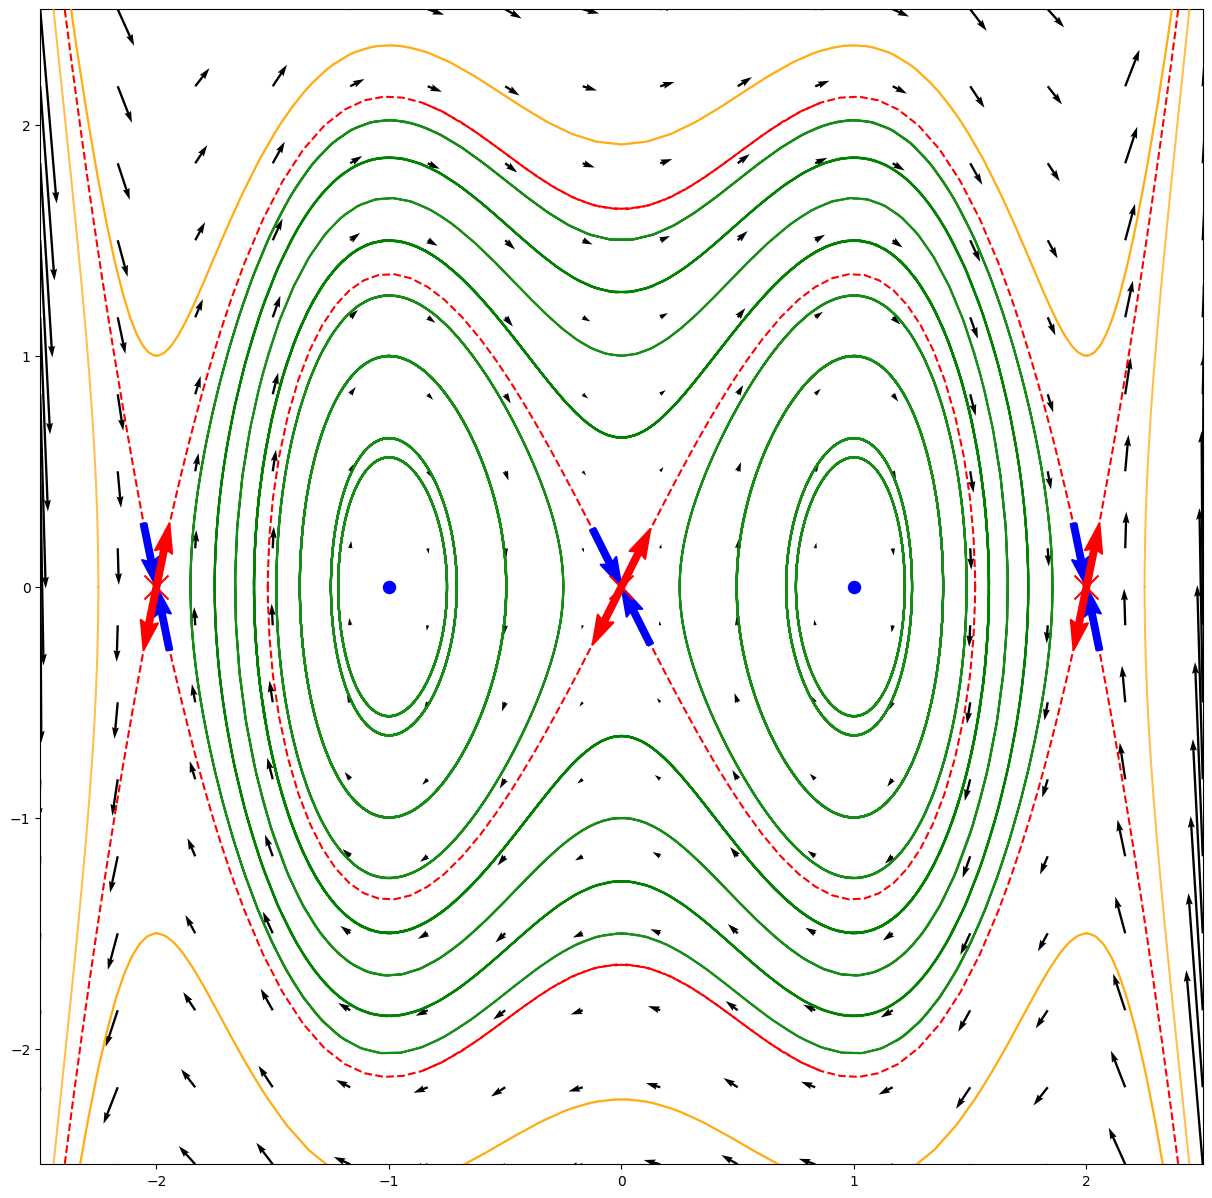

In [71]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
#alpha = -2*(pow(6,1/2))
alpha = 0
coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")



Замкнутые траектории:


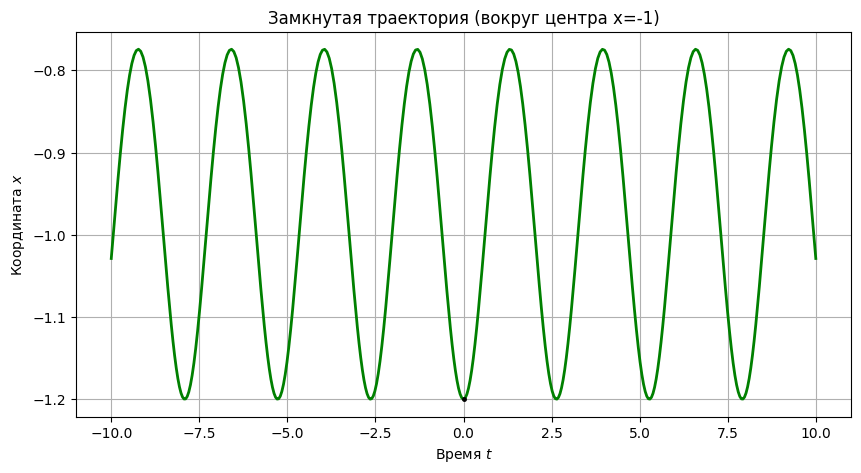

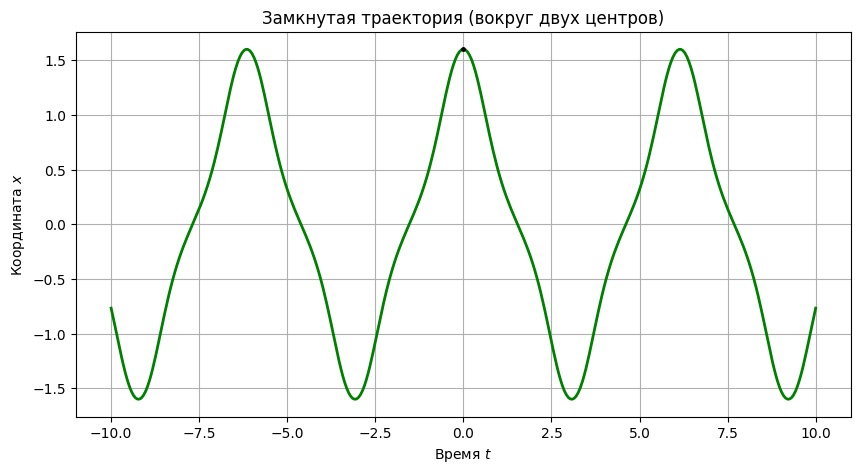

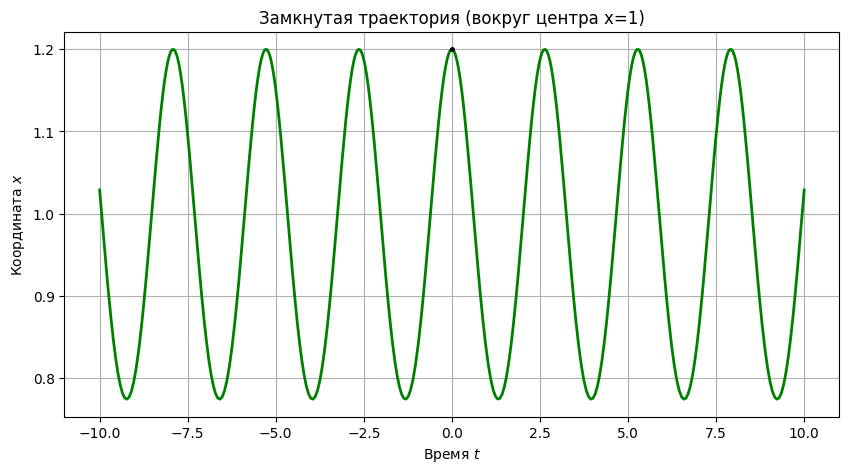

In [72]:
# замкнутые траектории
print ('Замкнутые траектории:')
X0 = [-1.2, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг центра x=-1)',
    color='green'
)
X0 = [1.6, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг двух центров)',
    color='green'
)
X0 = [1.2, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Замкнутая траектория (вокруг центра x=1)',
    color='green'
)

Состояния равновесия


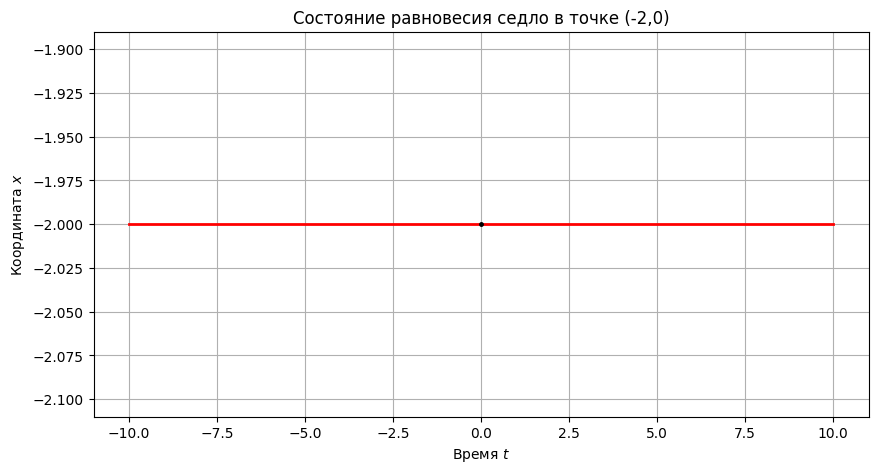

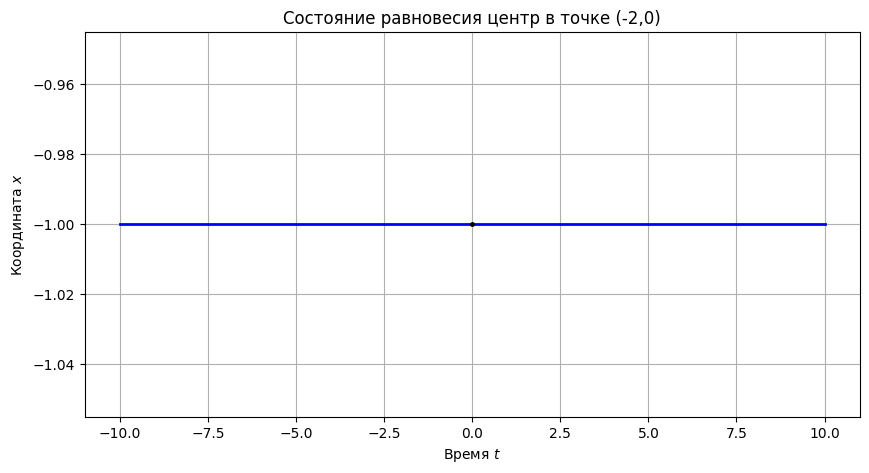

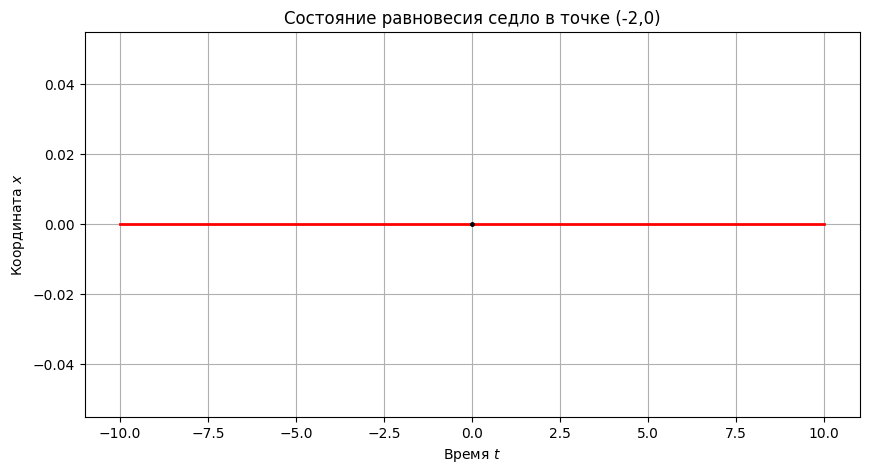

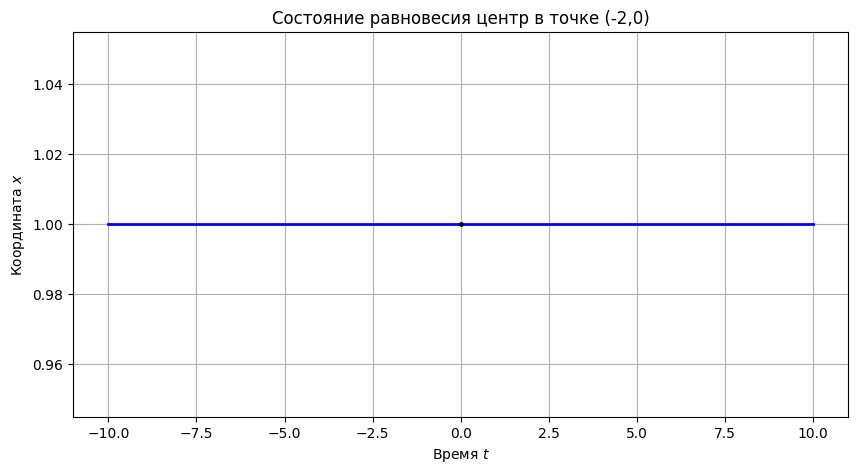

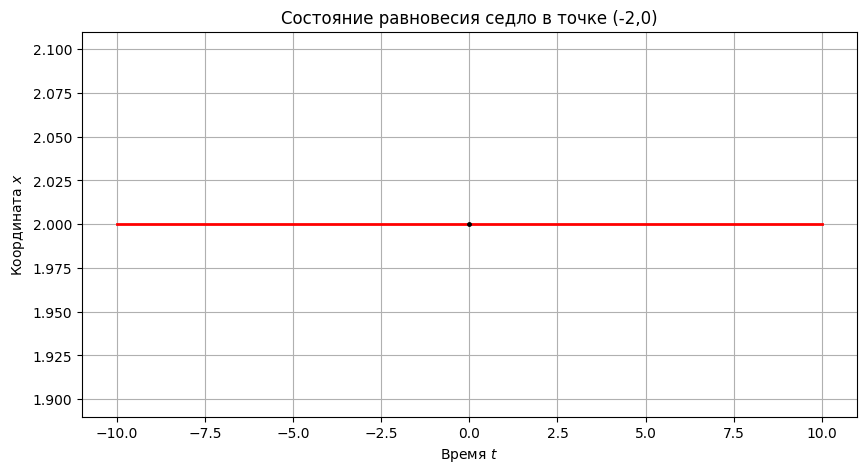

In [73]:
# состояния равновесия
print('Состояния равновесия')

for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    X0 = [x0,0.0]
    if type_number in {3, 4, 5, 6}:
        color_type = 'red'
    else:
        color_type = 'blue'
    plot_single_xt_realization(
        rhs=rhs,
        X0=X0,
        description=f'Состояние равновесия {type_name} в точке (-2,0)',
        color=color_type
    )



Лимитационно-инфинитные траектории


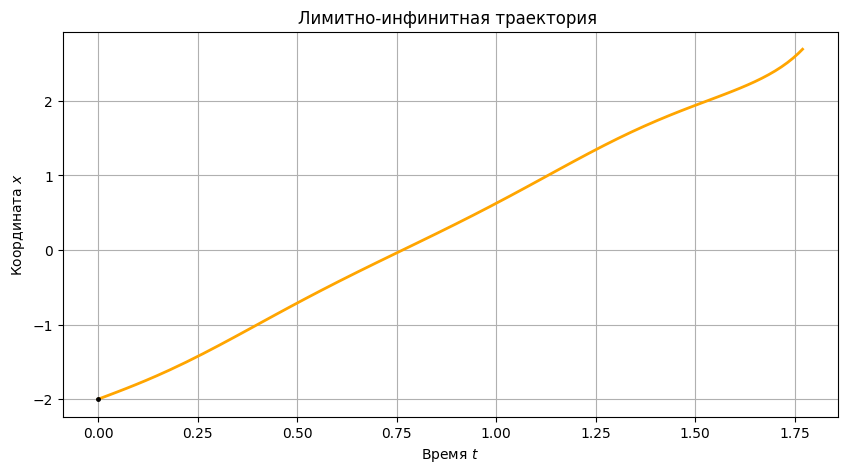

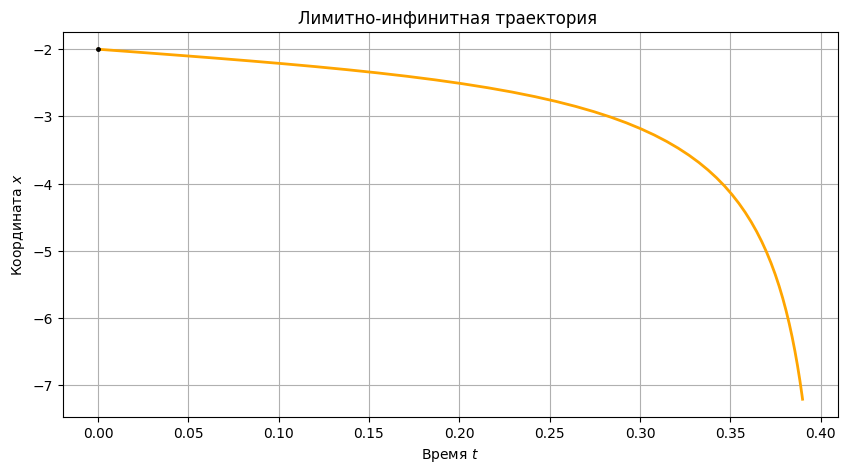

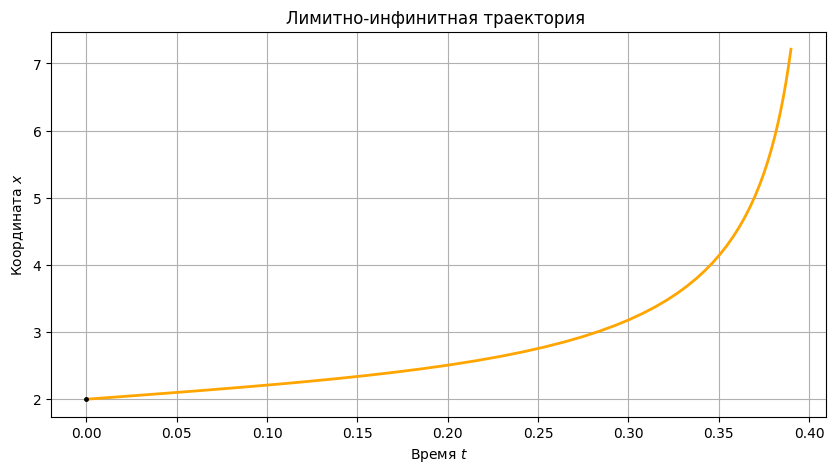

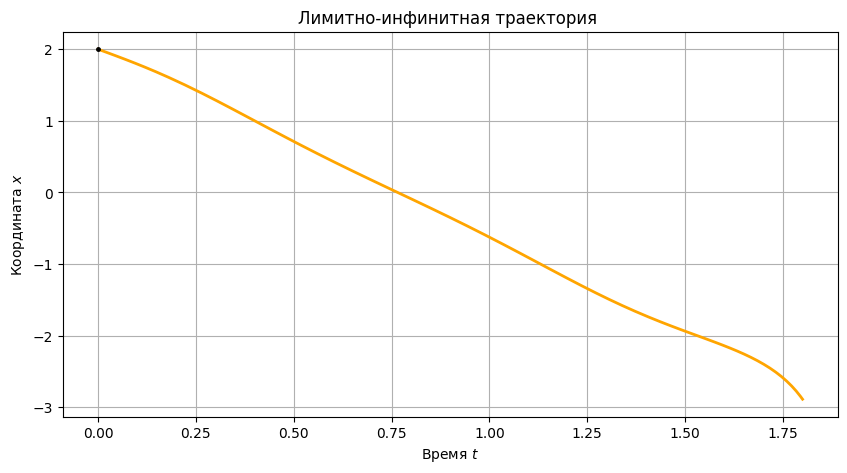

In [74]:
# лим инф
print('Лимитационно-инфинитные траектории')
X0 = [-2., 2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,1.77],
    color='orange'
)

X0 = [-2., -2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,0.39],
    color='orange'
)

X0 = [2., 2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,0.39],
    color='orange'
)

X0 = [2., -2.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Лимитно-инфинитная траектория ',
    t_val = [0,1.8],
    color='orange'
)

Инфинитные траектории


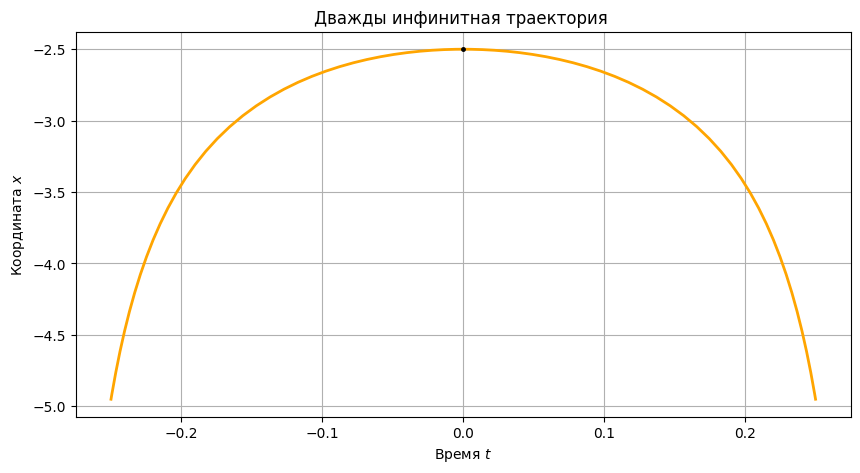

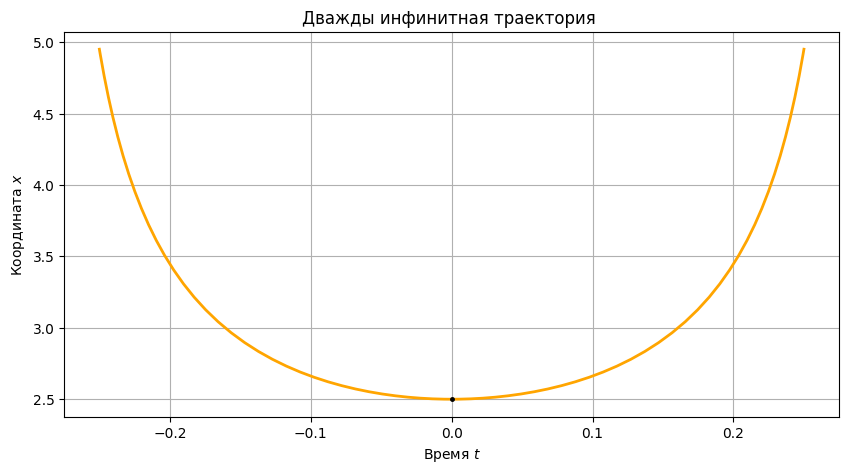

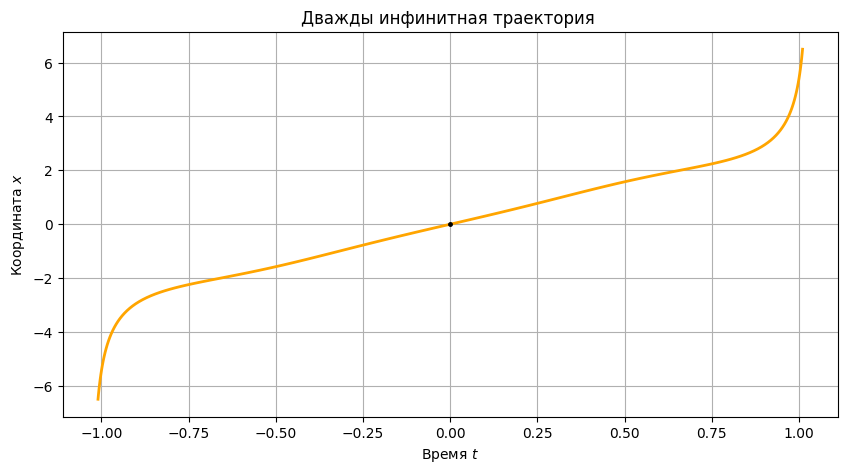

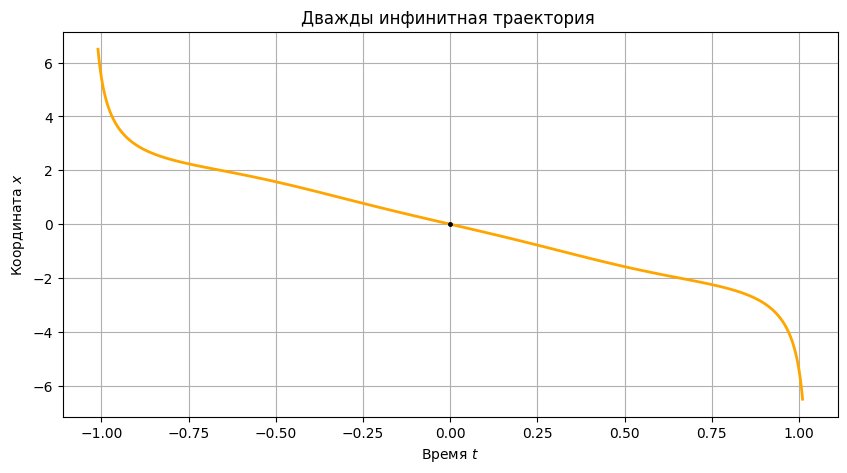

In [75]:
# дважды инф
print('Инфинитные траектории')
X0 = [-2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [0., 3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)

X0 = [0., -3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)


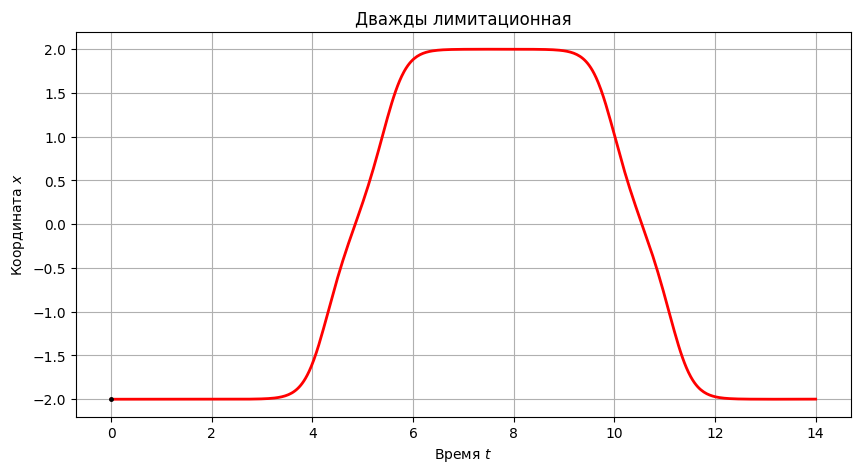

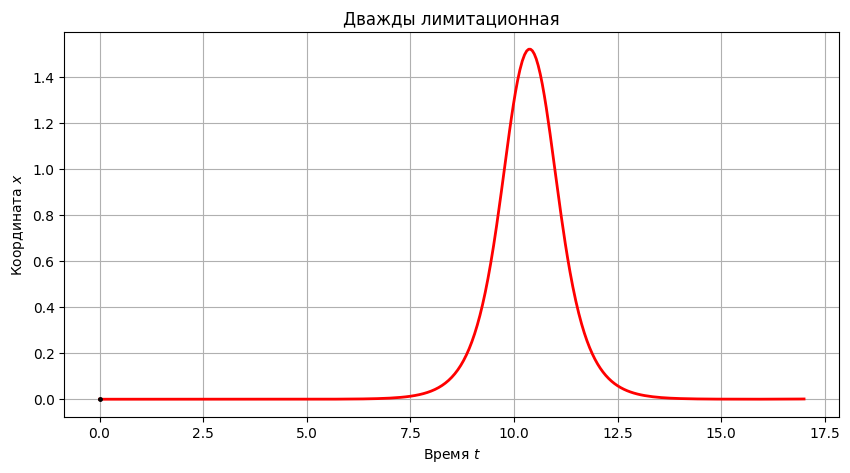

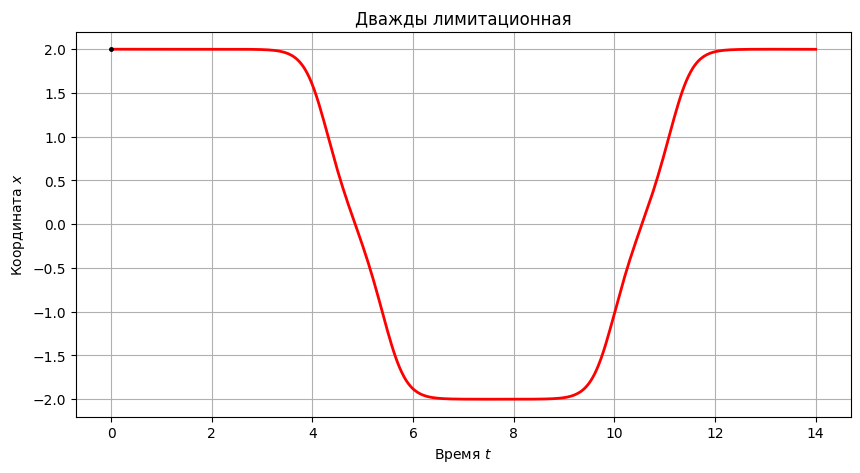

In [76]:
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)

x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 17],
    color='red'
)

x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)


[-2.  2. -1.  1.  0.]
alpha = -4.898979485566356
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [-3.02773583  7.92671532]
Собственные вектора = [[-0.31361704 -0.12516359]
 [ 0.94954955 -0.99213612]]
---------------------------
Точка P(-1.0, 0.0)
Тип: неустойчивый вырожденный узел
Собственные числа = [2.44948974+3.33200094e-08j 2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447+5.14138907e-09j -0.37796447-5.14138907e-09j]
 [-0.9258201 +0.00000000e+00j -0.9258201 -0.00000000e+00j]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [-0.71278792  5.6117674 ]
Собственные вектора = [[-0.81430994 -0.17543338]
 [ 0.58043029 -0.98449131]]
---------------------------
Точка P(1.0, 0.0)
Тип: неустойчивый вырожденный узел
Собственные числа = [2.44948974+3.33200094e-08j 2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447+5.14138907e-09j -0.37796447-5.14138907e-09j]
 [-0.9258201 +0.00000000

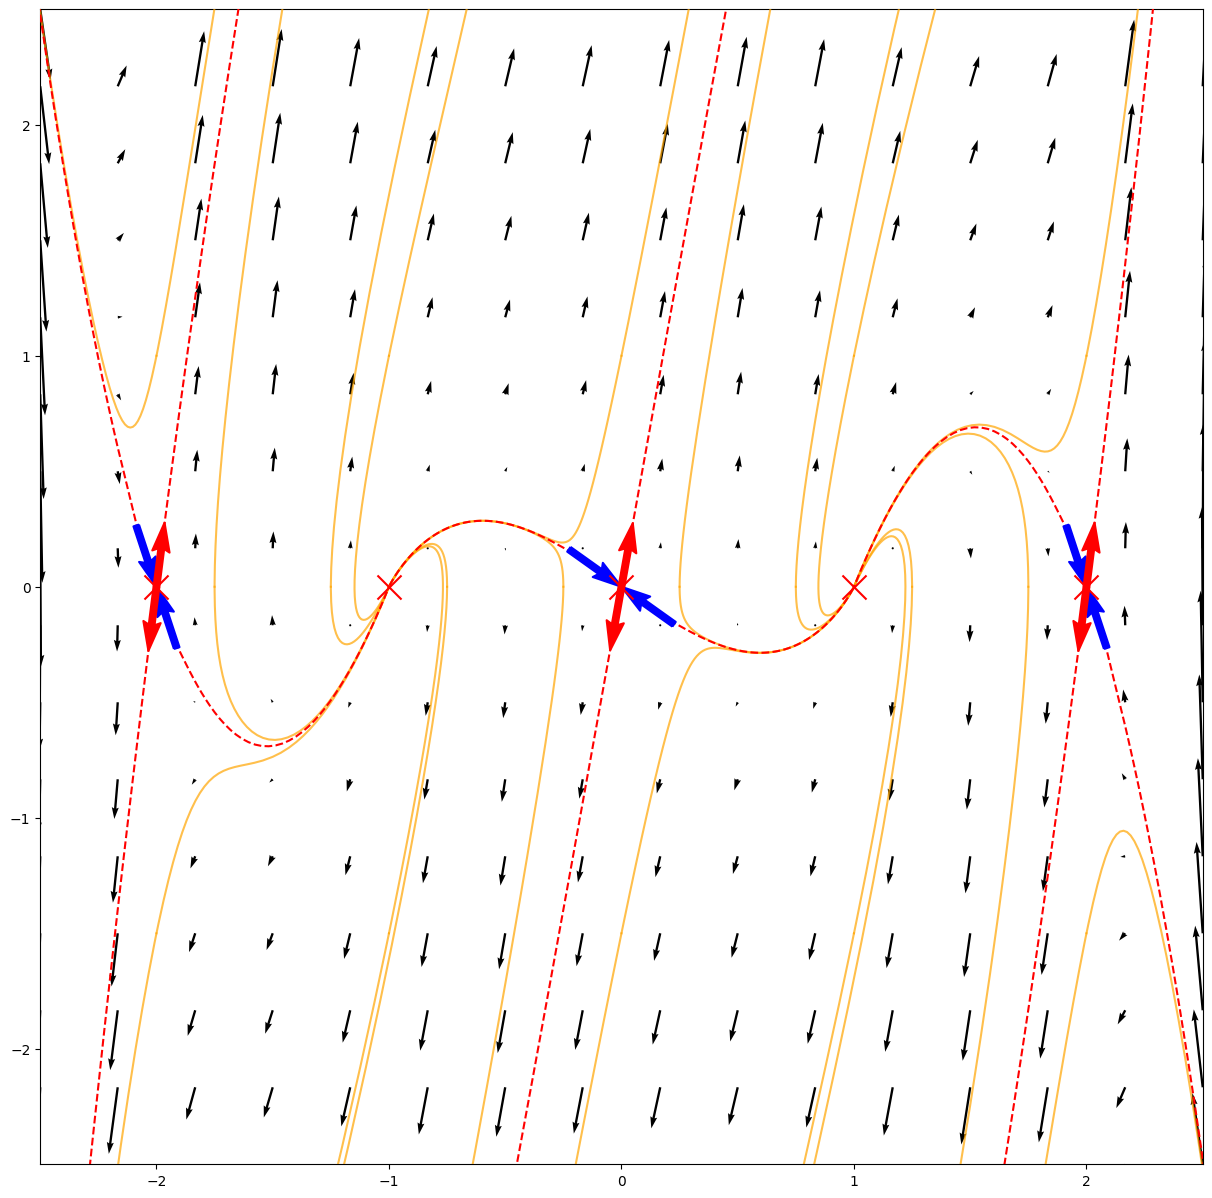

In [77]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = -2*(pow(6,1/2))

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

Состояния равновесия


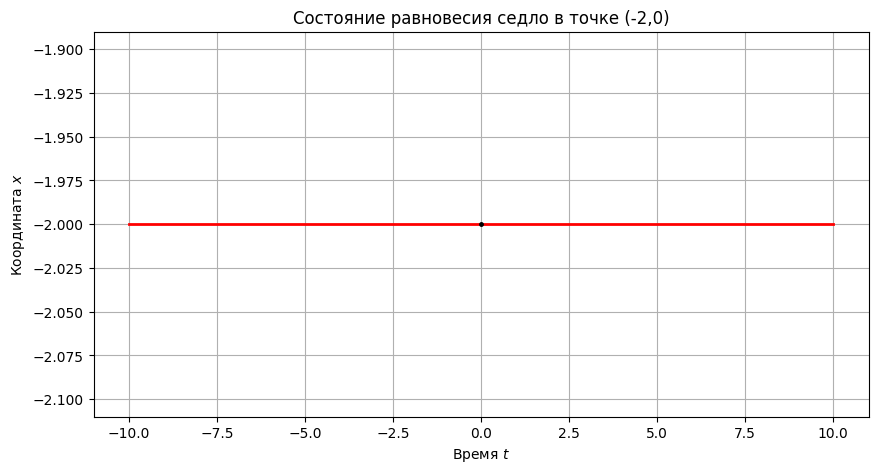

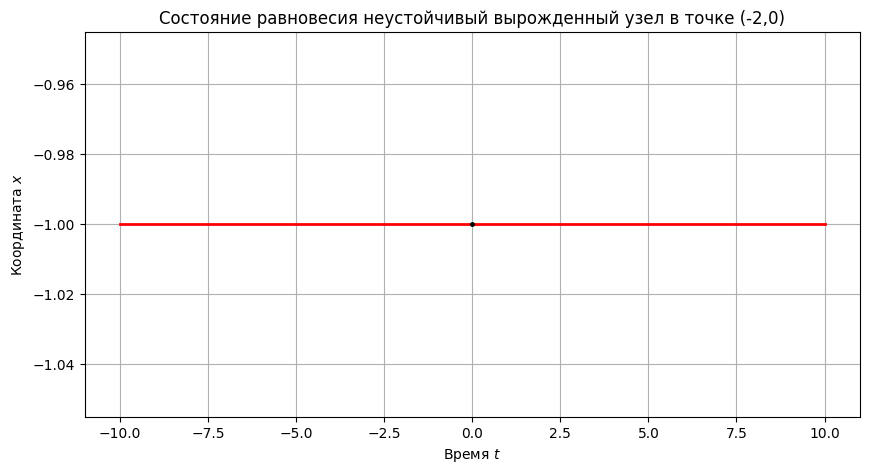

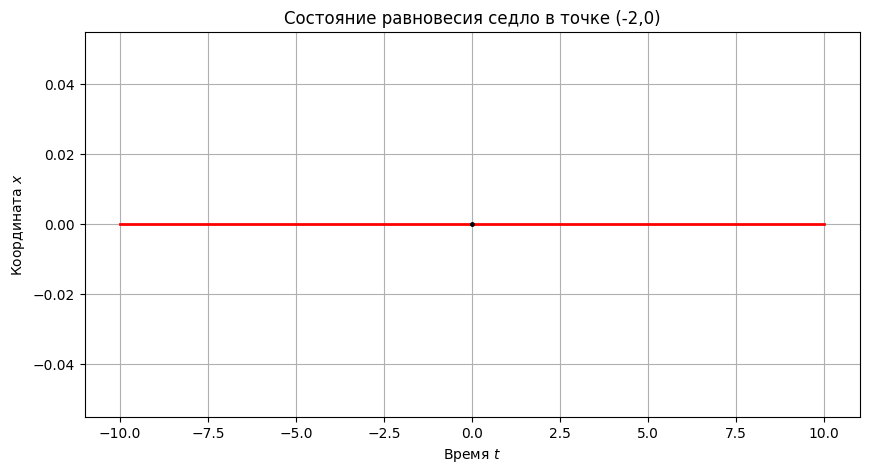

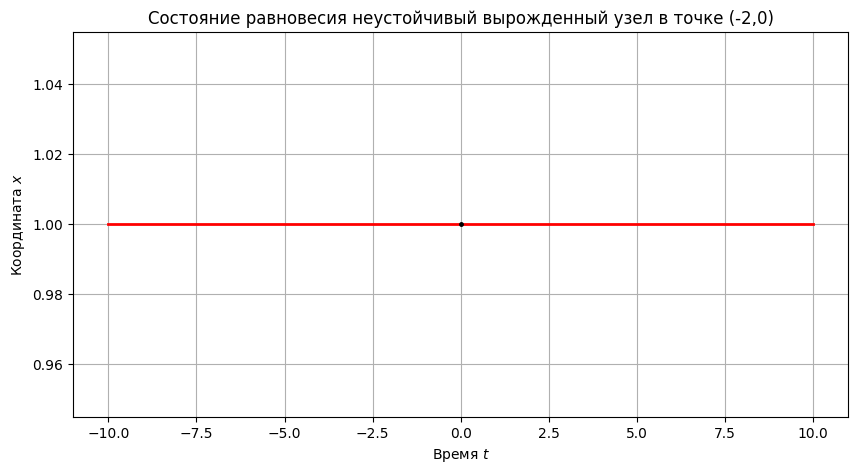

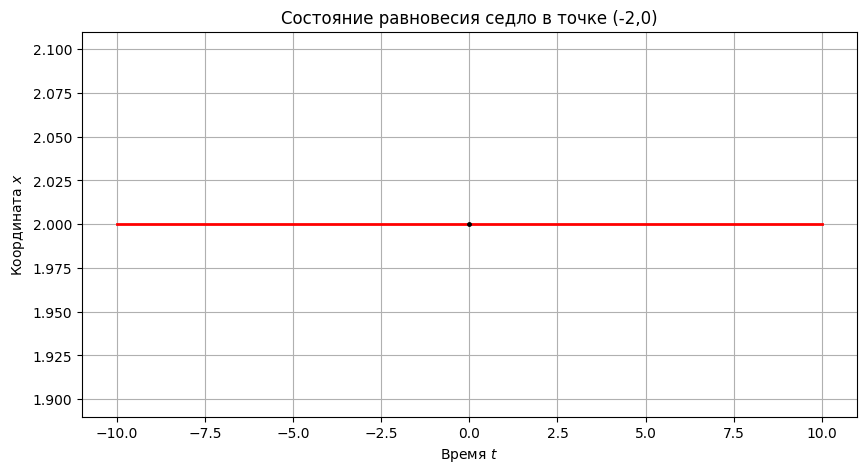

In [78]:
# состояния равновесия
print('Состояния равновесия')

for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    X0 = [x0,0.0]
    if type_number in {3, 4, 5, 6}:
        color_type = 'red'
    else:
        color_type = 'blue'
    plot_single_xt_realization(
        rhs=rhs,
        X0=X0,
        description=f'Состояние равновесия {type_name} в точке (-2,0)',
        color=color_type
    )


Лимитационно-инфинитные траектории


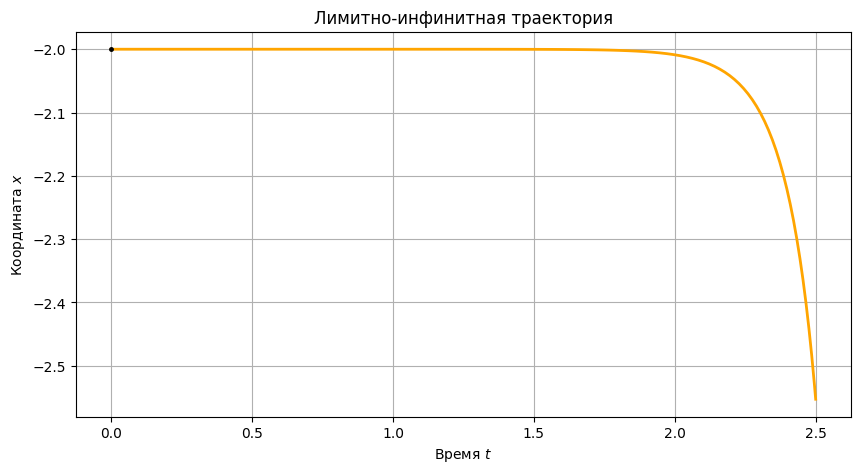

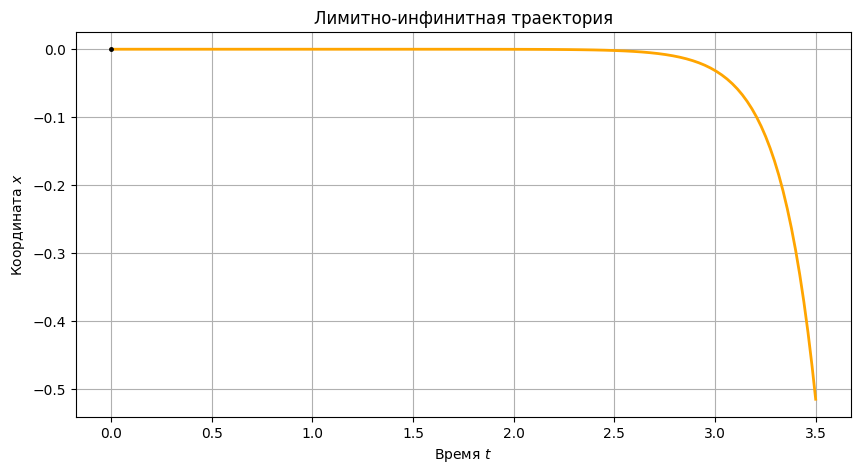

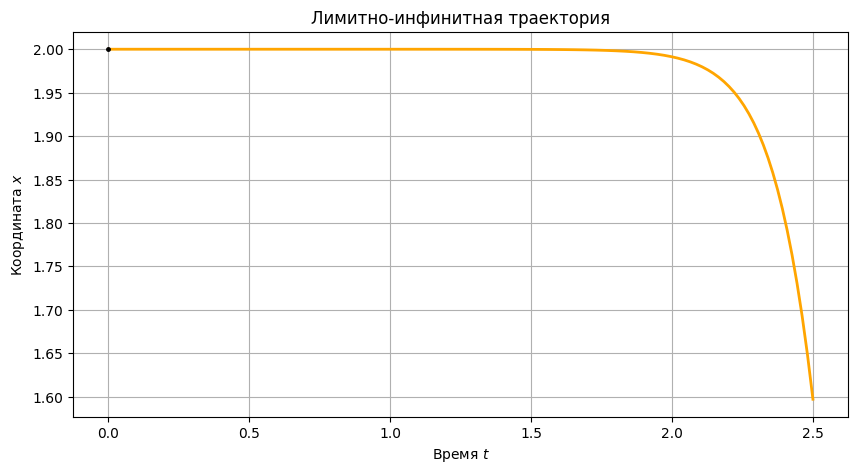

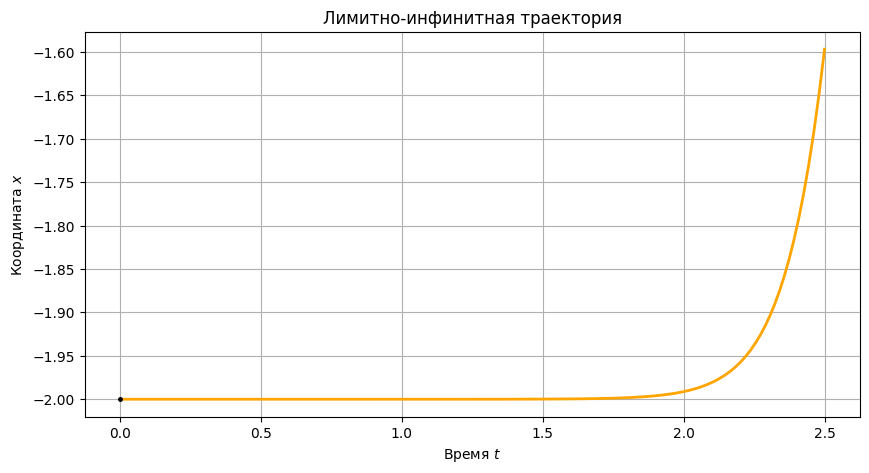

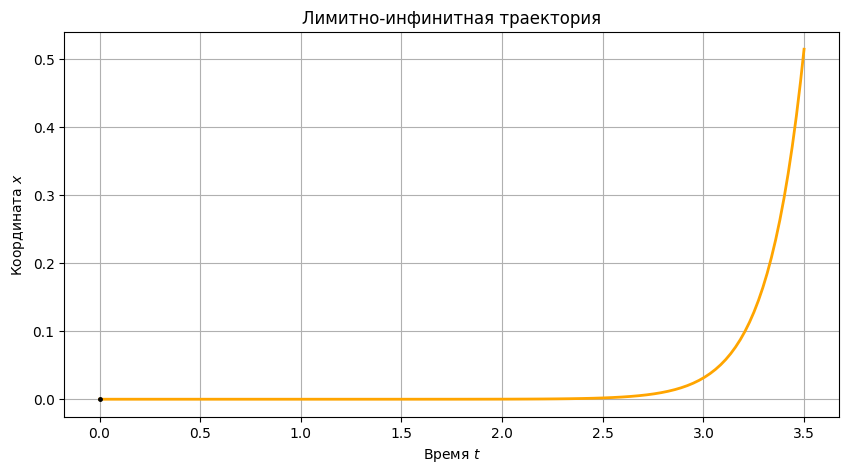

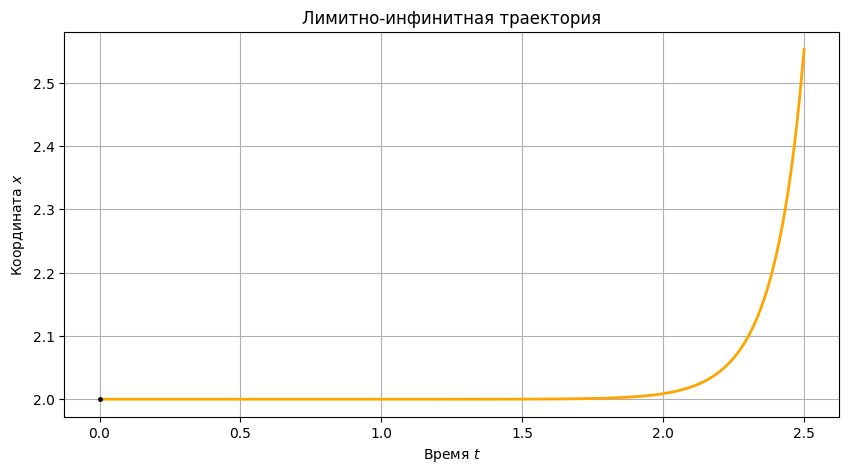

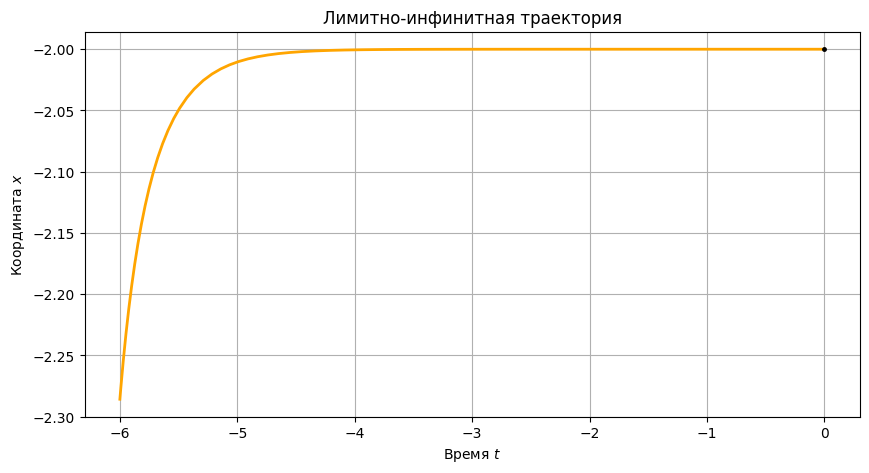

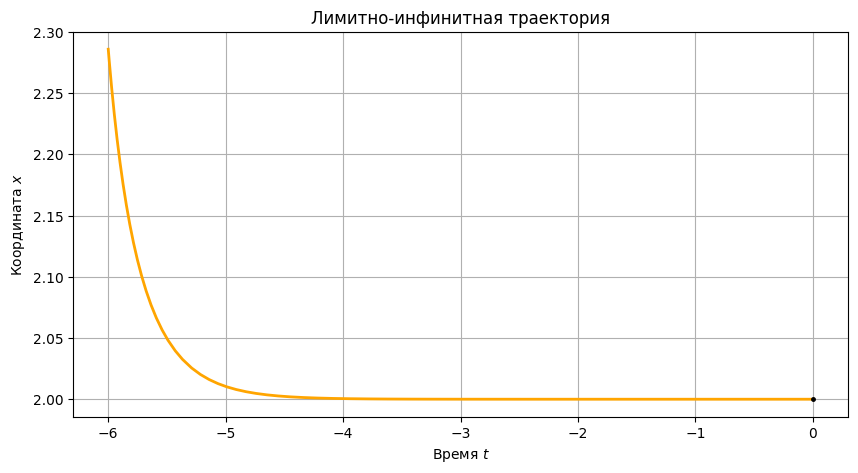

In [79]:
# лим инф
print('Лимитационно-инфинитные траектории')
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 3.5],
    color='orange'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)


x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 3.5],
    color='orange'
)


x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Лимитно-инфинитная траектория',
    t_val=[0, 2.5],
    color='orange'
)

x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_s, # уст вектор
    description='Лимитно-инфинитная траектория',
    t_val=[-6., 0.],
    color='orange'
)





x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_s, # уст вектор
    description='Лимитно-инфинитная траектория',
    t_val=[-6., 0.],
    color='orange'
)




Инфинитные траектории


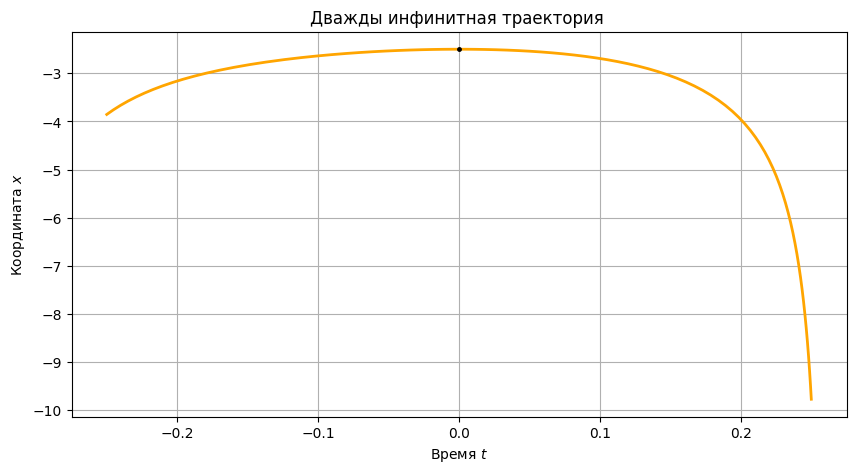

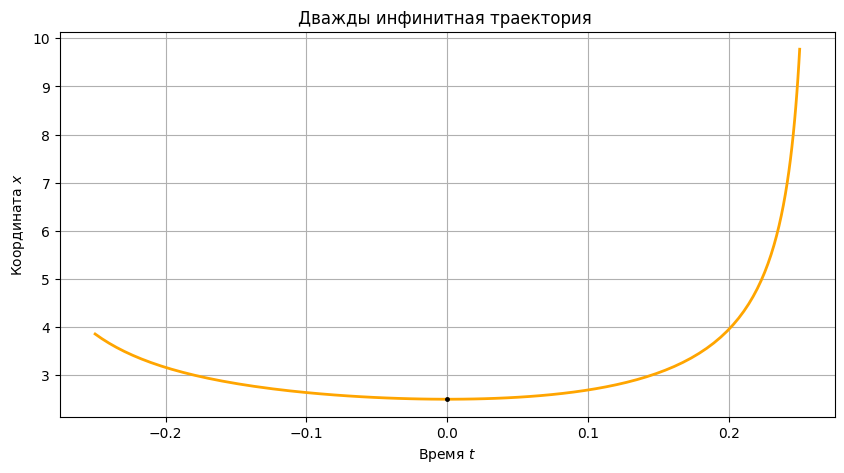

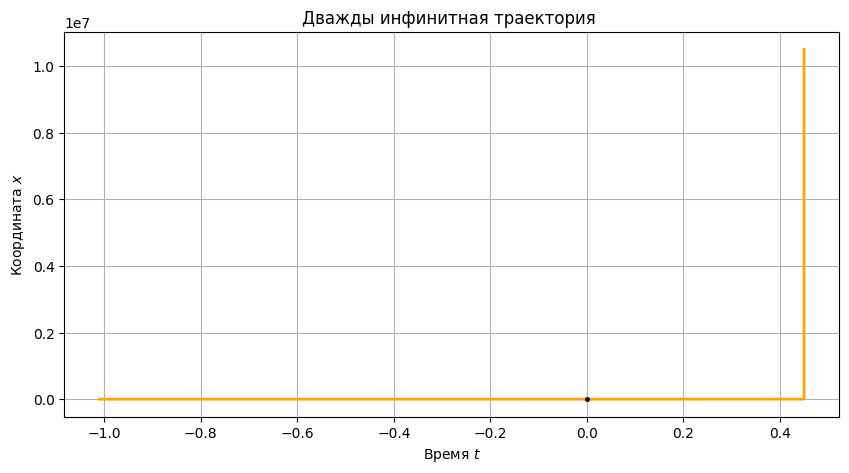

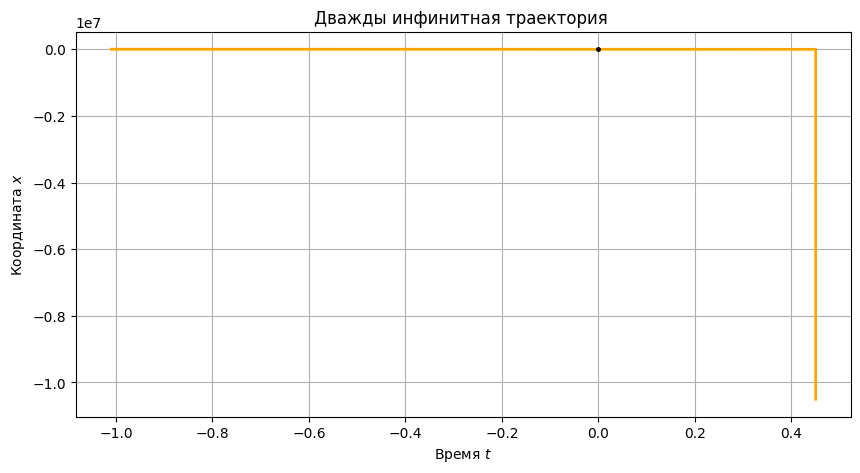

In [80]:
# дважды инф
print('Инфинитные траектории')
X0 = [-2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [2.5, 0.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-0.25,0.25],
    color='orange'
)

X0 = [0., 3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)

X0 = [0., -3.]
plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    description='Дважды инфинитная траектория ',
    t_val = [-1.01,1.01],
    color='orange'
)

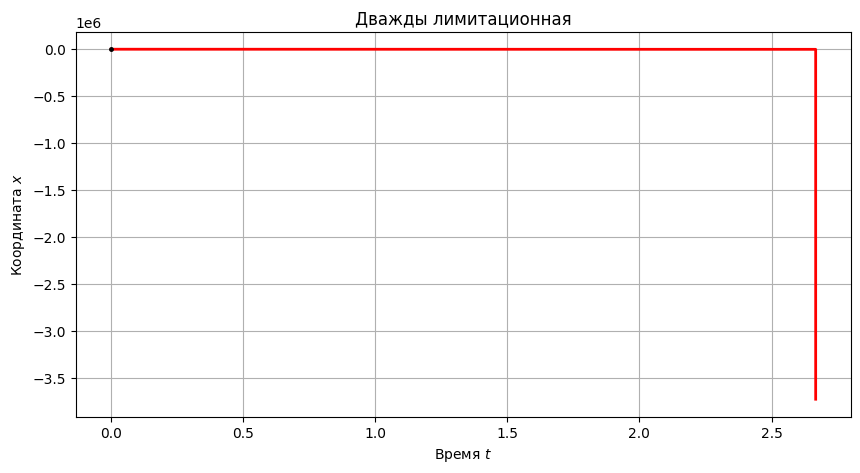

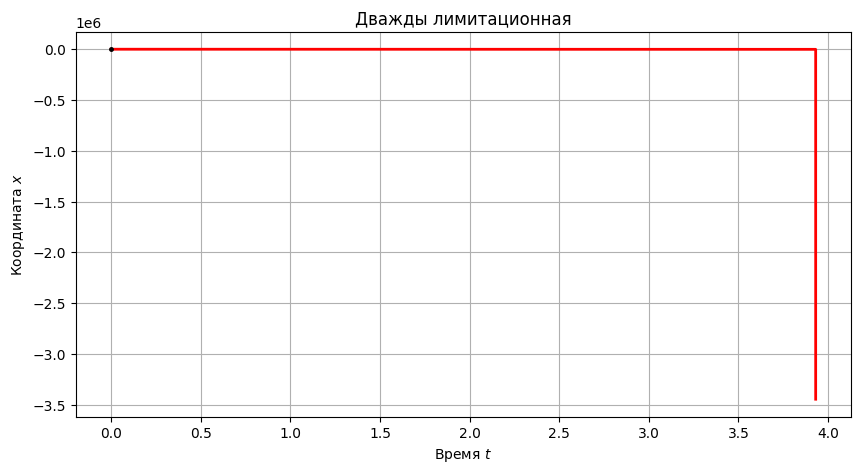

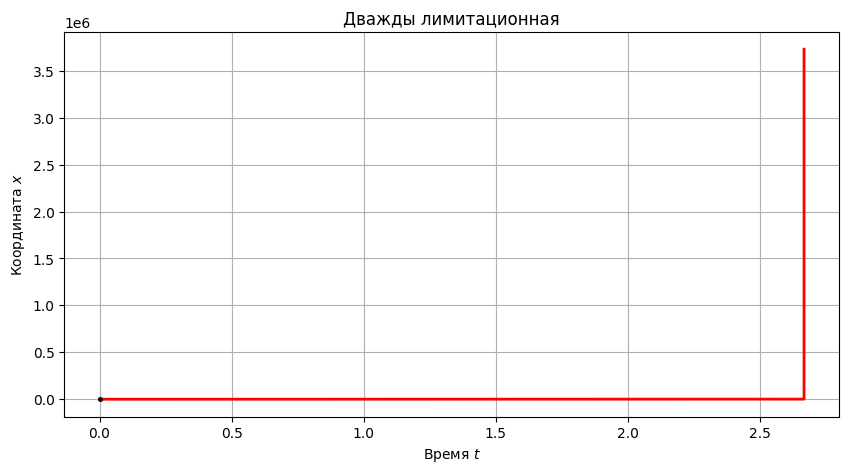

In [81]:
x0 = -2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)

x0 = 0.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 17],
    color='red'
)

x0 = 2.0
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
type_name, type_number = stability_type(eigenvalues) # Получаем тип
X0 = [x0,0.]
# 1. Определяем устойчивый (v_s) и неустойчивый (v_u) векторы
l1, l2 = eigenvalues[0].real, eigenvalues[1].real
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]
X_eq = [x0, 0.0]

if l1 < 0:
    v_s, v_u = v1, v2 # v1 устойчивый
else:
    v_s, v_u = v2, v1 # v2 устойчивый

plot_single_xt_realization(
    rhs=rhs,
    X0=X0,
    v_sep=-v_u, # Неустойчивый вектор
    description='Дважды лимитационная',
    t_val=[0, 14],
    color='red'
)


[-2.  2. -1.  1.  0.]
alpha = 4.898979485566356
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 3.02773583 -7.92671532]
Собственные вектора = [[ 0.31361704 -0.12516359]
 [ 0.94954955  0.99213612]]
---------------------------
Точка P(-1.0, 0.0)
Тип: устойчивый вырожденный узел
Собственные числа = [-2.44948974+3.33200094e-08j -2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447-5.14138907e-09j -0.37796447+5.14138907e-09j]
 [ 0.9258201 +0.00000000e+00j  0.9258201 -0.00000000e+00j]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 0.71278792 -5.6117674 ]
Собственные вектора = [[ 0.81430994 -0.17543338]
 [ 0.58043029  0.98449131]]
---------------------------
Точка P(1.0, 0.0)
Тип: устойчивый вырожденный узел
Собственные числа = [-2.44948974+3.33200094e-08j -2.44948974-3.33200094e-08j]
Собственные вектора = [[-0.37796447-5.14138907e-09j -0.37796447+5.14138907e-09j]
 [ 0.9258201 +0.00000000e

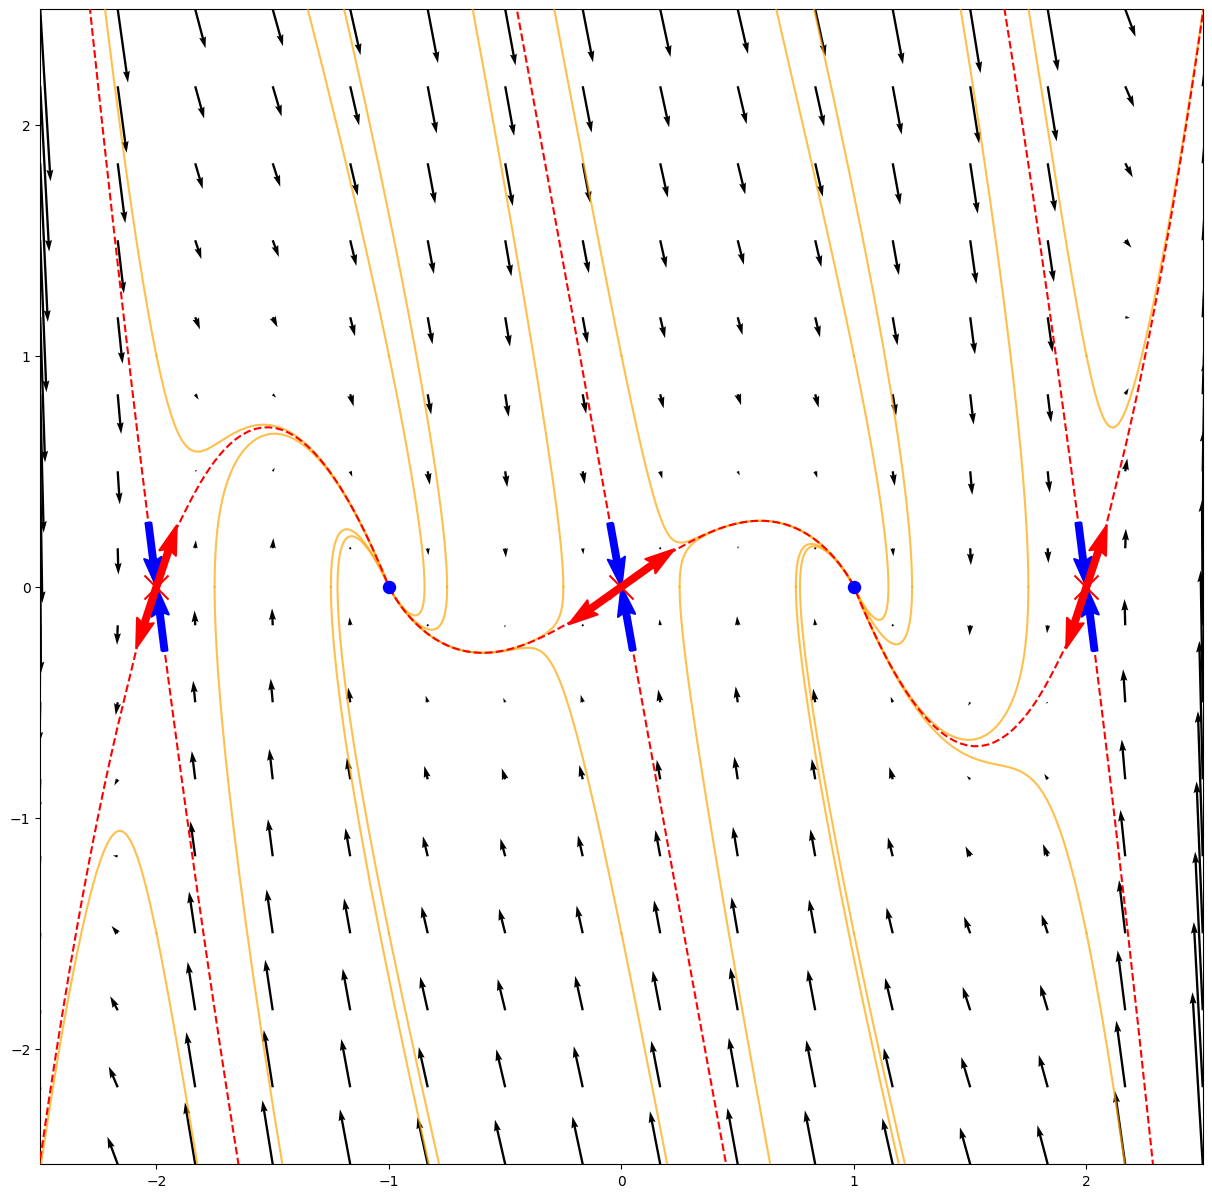

In [82]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = 2*(pow(6,1/2))

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

[-2.  2. -1.  1.  0.]
alpha = -5
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [-3.  8.]
Собственные вектора = [[-0.31622777 -0.12403473]
 [ 0.9486833  -0.99227788]]
---------------------------
Точка P(-1.0, 0.0)
Тип: неустойчивый узел
Собственные числа = [2. 3.]
Собственные вектора = [[-0.4472136  -0.31622777]
 [-0.89442719 -0.9486833 ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [-0.70156212  5.70156212]
Собственные вектора = [[-0.81863069 -0.17275355]
 [ 0.57432028 -0.98496508]]
---------------------------
Точка P(1.0, 0.0)
Тип: неустойчивый узел
Собственные числа = [2. 3.]
Собственные вектора = [[-0.4472136  -0.31622777]
 [-0.89442719 -0.9486833 ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [-3.  8.]
Собственные вектора = [[-0.31622777 -0.12403473]
 [ 0.9486833  -0.99227788]]
---------------------------


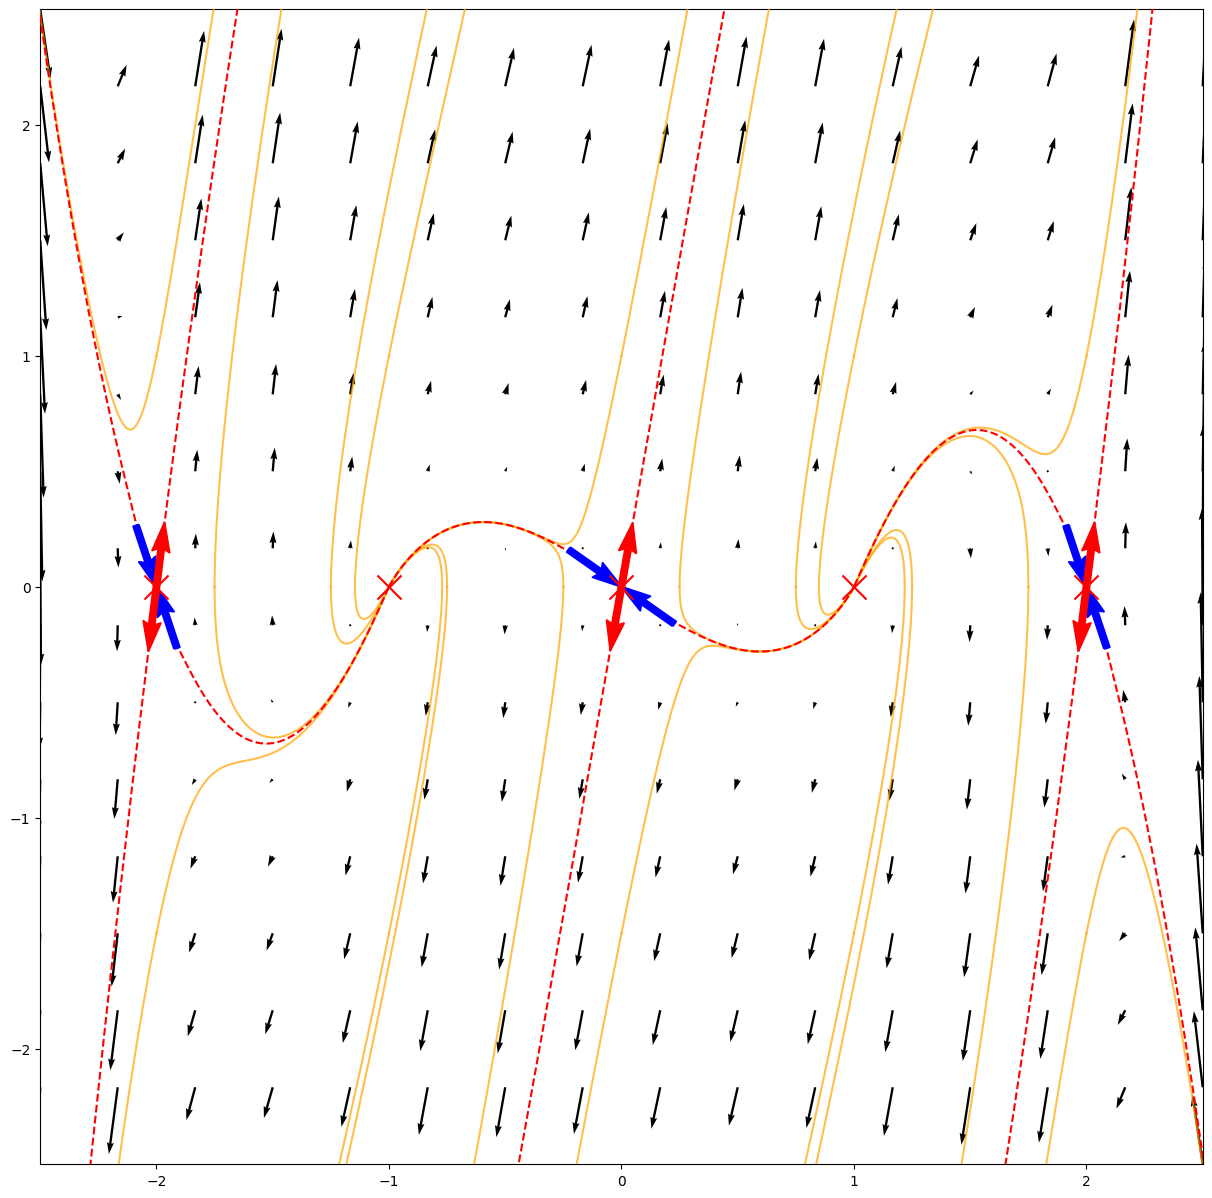

In [83]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = -5

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")

[-2.  2. -1.  1.  0.]
alpha = 5
Для системы: x' = y,
 y' = x^5 - 5x^3 + 4x + (-alpha)*y

Точка P(-2.0, 0.0)
Тип: седло
Собственные числа = [ 3. -8.]
Собственные вектора = [[ 0.31622777 -0.12403473]
 [ 0.9486833   0.99227788]]
---------------------------
Точка P(-1.0, 0.0)
Тип: устойчивый узел
Собственные числа = [-2. -3.]
Собственные вектора = [[ 0.4472136  -0.31622777]
 [-0.89442719  0.9486833 ]]
---------------------------
Точка P(0.0, 0.0)
Тип: седло
Собственные числа = [ 0.70156212 -5.70156212]
Собственные вектора = [[ 0.81863069 -0.17275355]
 [ 0.57432028  0.98496508]]
---------------------------
Точка P(1.0, 0.0)
Тип: устойчивый узел
Собственные числа = [-2. -3.]
Собственные вектора = [[ 0.4472136  -0.31622777]
 [-0.89442719  0.9486833 ]]
---------------------------
Точка P(2.0, 0.0)
Тип: седло
Собственные числа = [ 3. -8.]
Собственные вектора = [[ 0.31622777 -0.12403473]
 [ 0.9486833   0.99227788]]
---------------------------


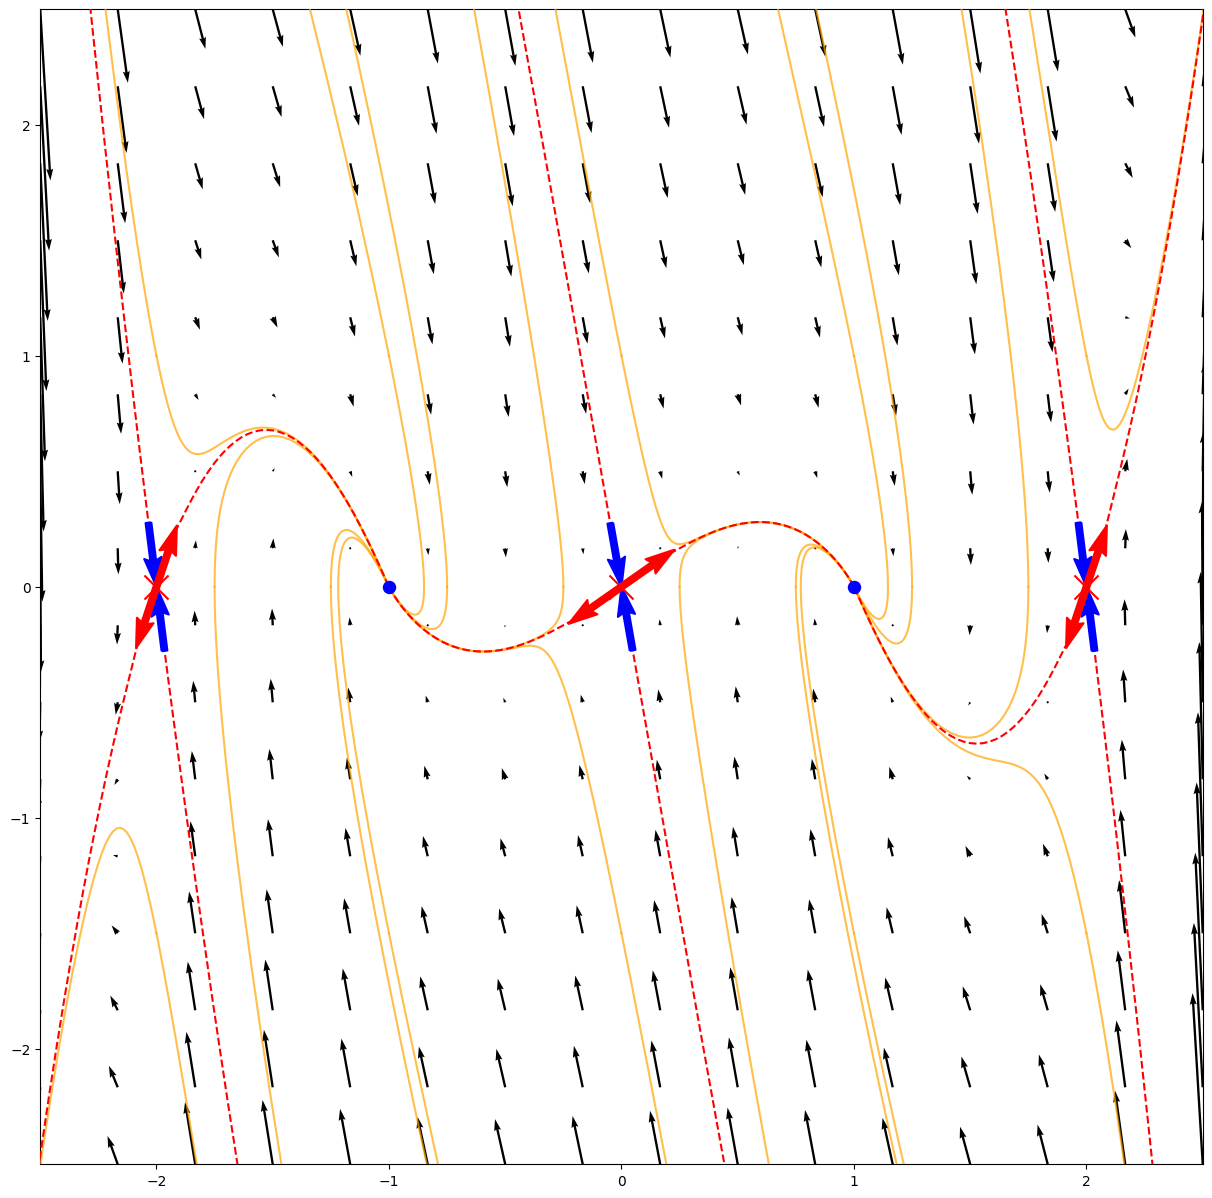

In [84]:

# x = +2 - седло (всегда) x = 0 - седло (всегда)
# x = +-1
# alpha = 0 центр
# alpha = -2*sqrt(6) неустойчивый вырожденный узел
# alpha = 2*sqrt(6) устойчивый вырожденный узел
# alpha = -1 Неустойчивый фокус (-2*sqrt(6) < alpha < 0)
# alpha = 1 Устойчивый фокус (0 < alpha < 2*sqrt(6))
# alpha = 5 Устойчивый узел ( alpha > 2*sqrt(6) )
# alpha = -5 Неустойчивый узел ( alpha < -2*sqrt(6) )
alpha = 5

coeff = [1,0,-5,0,4,0] # x^5 + 0x^4 - 5x^3 + 0x^2 + 4x + 0 - это фунция
x_korni = np.roots(coeff)
print (x_korni)

X0_eq = np.round(sorted(x_korni)) # x-координаты точек равновесия

print (f"alpha = {alpha}")
print("Для системы: x' = y,\n y' = x^5 - 5x^3 + 4x + (-alpha)*y\n")


rhs = f1(alpha)
plt.figure(figsize=(15, 15))
#fig, ax = plt.subplots()
#ax.set_aspect('equal', adjustable='box')
drawing_vector_field(rhs, [(-2.5,2.5),(-2.5,2.5)]) # Отрисовка векторного поля один раз

# 2. Главный цикл анализа
for x0 in X0_eq:
    # 2.1. Вычисление
    eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(alpha, x0)

    # 2.2. Классификация
    type_name, type_number = stability_type(eigenvalues) # Получаем тип

    # 2.3. Вывод
    print(f"Точка P({x0:.1f}, 0.0)")
    print(f"Тип: {type_name}")
    print(f"Собственные числа = {eigenvalues}")
    print(f"Собственные вектора = {eigenvectors}")


    # 2.4. Отрисовка (зависит от текущей точки)

    # Рисуем точку равновесия
    plot_equilibrium(type_number, (x0, 0)) # Необходимо передать координаты точки

    # Рисуем собственные векторы/сепаратрисы
    plot_eigendirections_arrows(eigenvalues, eigenvectors, type_number,(x0, 0), scale=0.5)

    t_max_val = 20 if type_number == 9 else 10
    initial_conditions_general = tochki_integrirovania(x0, 0,type_number,alpha)
    draw_trajectories_around_point(rhs, x0, 0, type_number,eigenvalues, eigenvectors,alpha,initial_conditions_general, t_max=t_max_val, offset=0.25)
    print("---------------------------")